**Importing relevant libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random
import math
from scipy import stats
from tqdm import tqdm
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, roc_curve, recall_score

**Loading the dataset**

In [3]:
df = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')
df.drop_duplicates(subset=['track_id'], inplace=True)
df.to_csv('cleaned_data.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116191 entries, 0 to 116371
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist_name       116191 non-null  object 
 1   track_id          116191 non-null  object 
 2   track_name        116190 non-null  object 
 3   acousticness      116191 non-null  float64
 4   danceability      116191 non-null  float64
 5   duration_ms       116191 non-null  int64  
 6   energy            116191 non-null  float64
 7   instrumentalness  116191 non-null  float64
 8   key               116191 non-null  int64  
 9   liveness          116191 non-null  float64
 10  loudness          116191 non-null  float64
 11  mode              116191 non-null  int64  
 12  speechiness       116191 non-null  float64
 13  tempo             116191 non-null  float64
 14  time_signature    116191 non-null  int64  
 15  valence           116191 non-null  float64
 16  popularity        116191 

**Analysis of each feature**

In [ ]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate the mean and variances of each numerical column
column_means = df[numerical_columns].mean(axis=0)
column_variances = df[numerical_columns].var(axis=0)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Column Name': numerical_columns,
    'Mean': column_means,
    'Standard Deviation': column_variances**(0.5)
})

# Display the results side by side
print(results_df.to_string())

                       Column Name           Mean  Standard Deviation
acousticness          acousticness       0.335555            0.343098
danceability          danceability       0.582413            0.189884
duration_ms            duration_ms  212551.162577       124397.574690
energy                      energy       0.571773            0.258595
instrumentalness  instrumentalness       0.230363            0.363526
key                            key       5.240681            3.603911
liveness                  liveness       0.194200            0.167419
loudness                  loudness      -9.947945            6.505176
mode                          mode       0.607655            0.488275
speechiness            speechiness       0.112177            0.124402
tempo                        tempo     119.600427           30.148566
time_signature      time_signature       3.882874            0.508817
valence                    valence       0.438361            0.259608
popularity          

**Step-0: Exploratory Data Analysis**

Distribution of Popularity Scores

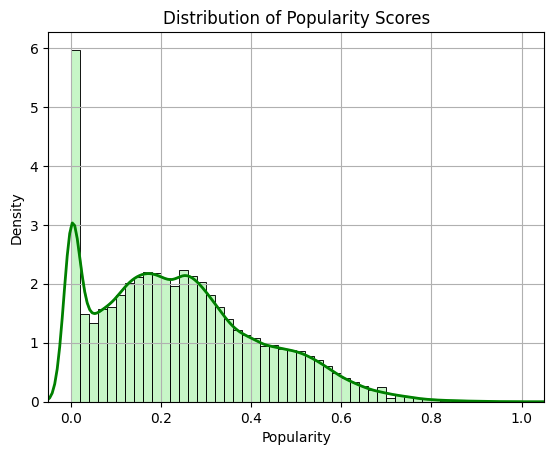

In [ ]:
sns.histplot(data=df['popularity']/100, bins=50, color='lightgreen', kde=True, stat='density')
sns.kdeplot(data=df['popularity']/100, color='green', linewidth=2)

plt.xlim(-0.05, 1.05)
plt.grid(axis='x')
plt.grid(axis='y')

plt.title('Distribution of Popularity Scores')
plt.xlabel('Popularity')
plt.ylabel('Density')

plt.show()

Scatter Plots of various features

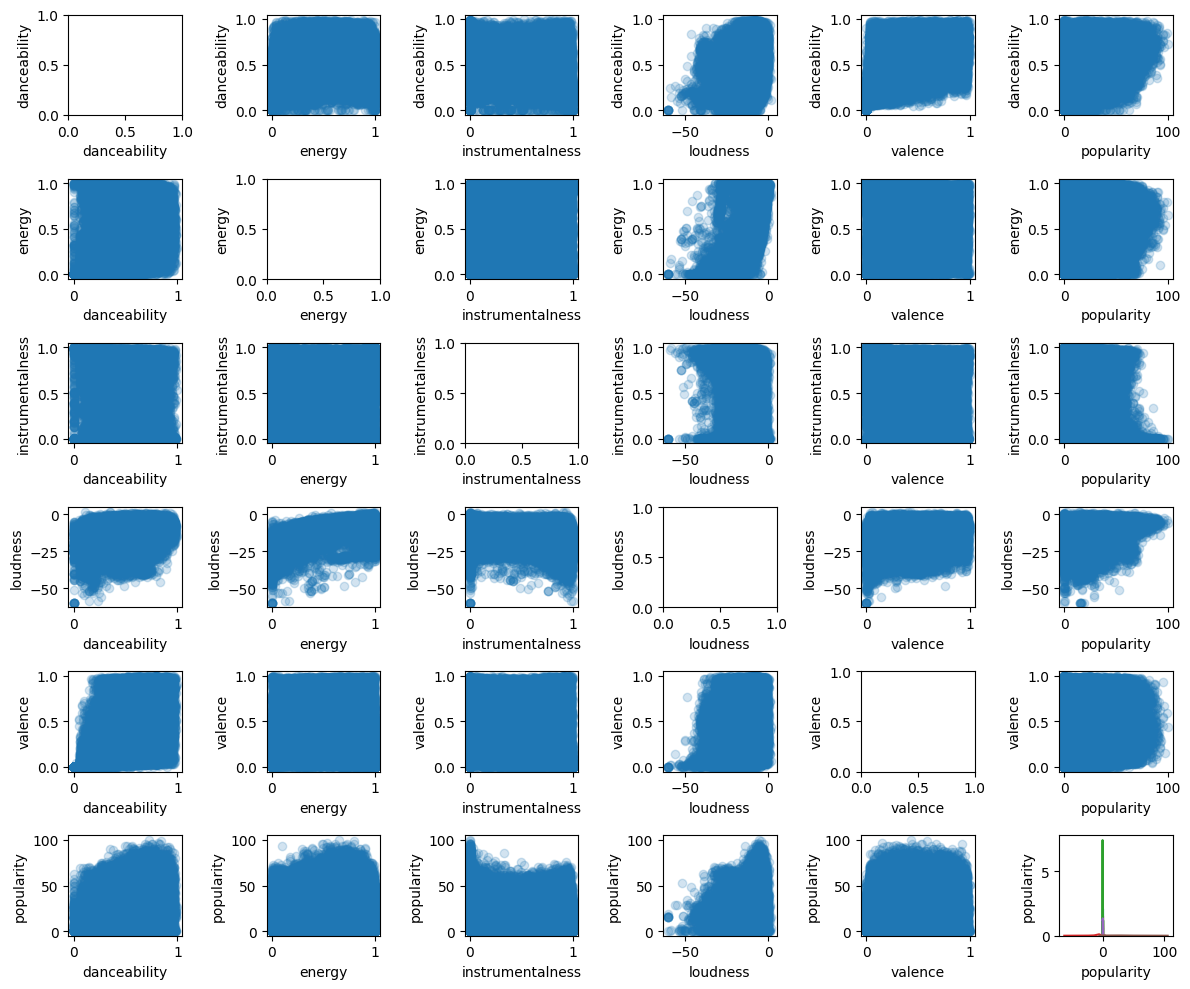

In [ ]:
# Define the features you want to plot
features = ["danceability", "energy", "instrumentalness", "loudness", "valence", "popularity"]

# Initialize the subplot grid
fig, axes = plt.subplots(6, 6, figsize=(12, 10))

# Iterate through each pair of features and create a scatter plot
for i in range(6):
    for j in range(6):
        if(i==j):
          feature1 = features[i]
          ax = axes[j][i]
          sns.kdeplot(df[feature1])
          ax.set_xlabel(feature1)
          ax.set_ylabel(feature1)
        else:
          feature1 = features[i]
          feature2 = features[j]
          ax = axes[j][i]
          ax.scatter(df[feature1], df[feature2], alpha=0.2)
          ax.set_xlabel(feature1)
          ax.set_ylabel(feature2)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


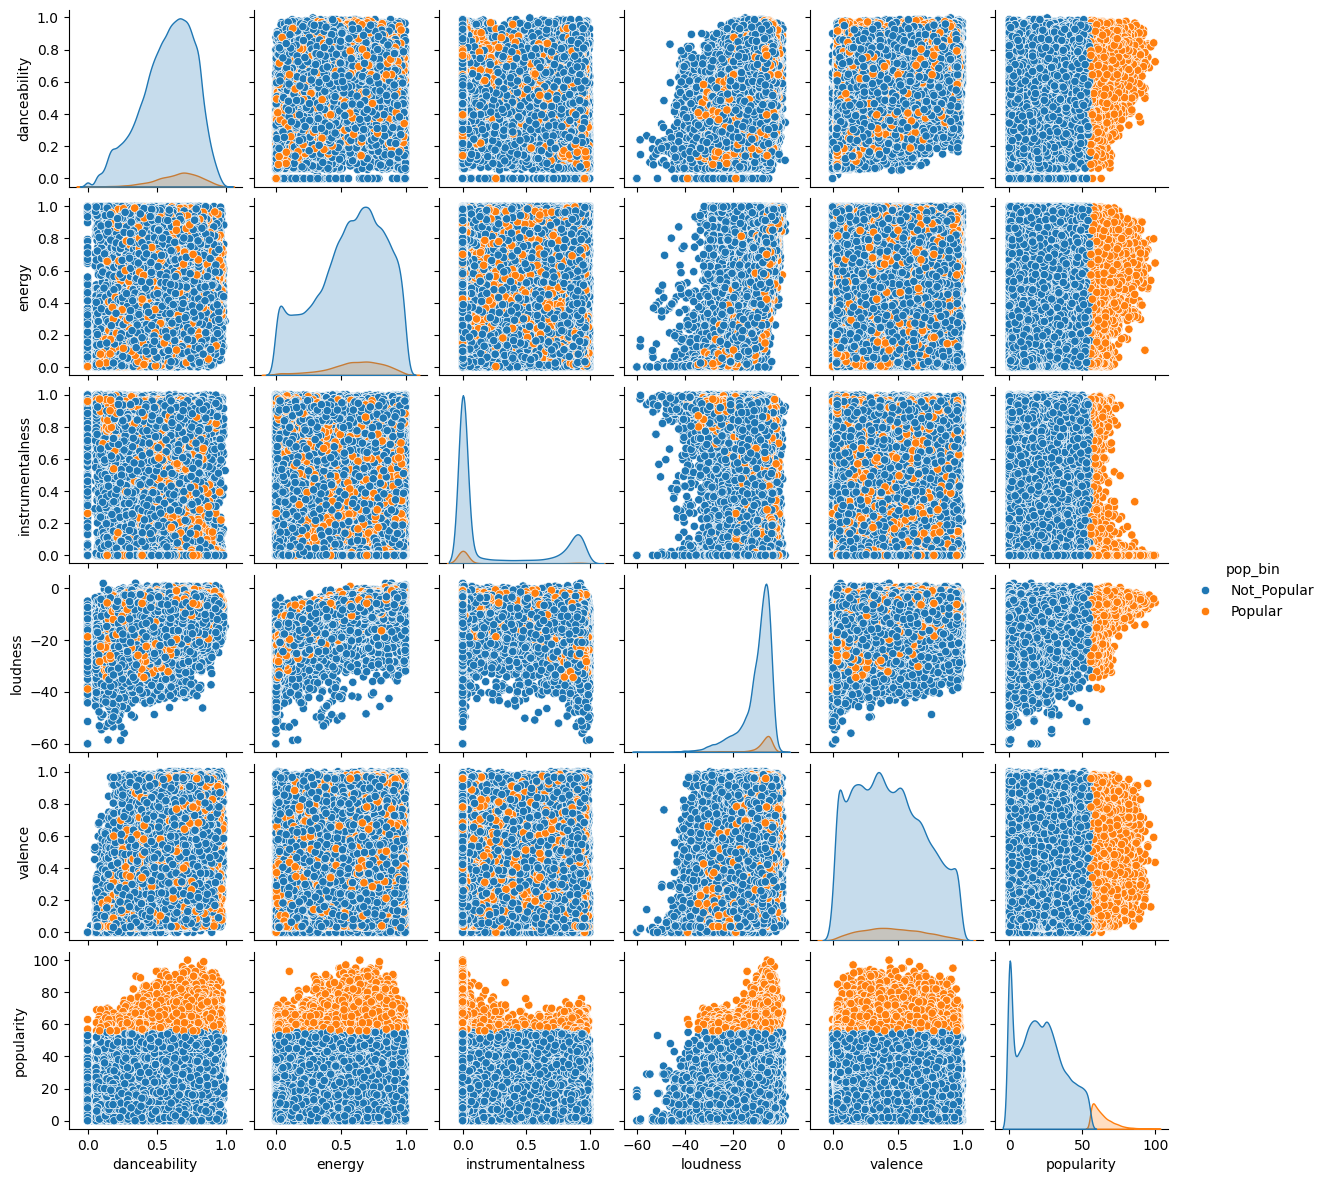

In [ ]:
def plot_pairplot(df, rows, cutoff):
    df = df.copy()
    df['pop_bin'] = np.where(df['popularity'] > cutoff, "Popular", "Not_Popular")
    cols_for_pp = ['danceability', 'energy', 'instrumentalness',
       'loudness','valence', 'popularity', 'pop_bin']
    sns.pairplot(df.loc[:rows, cols_for_pp], hue='pop_bin', size=2)
    plt.show()

plot_pairplot(df, rows = 116000, cutoff = 55)

Violin Plots to check similarity between mean of independent variables

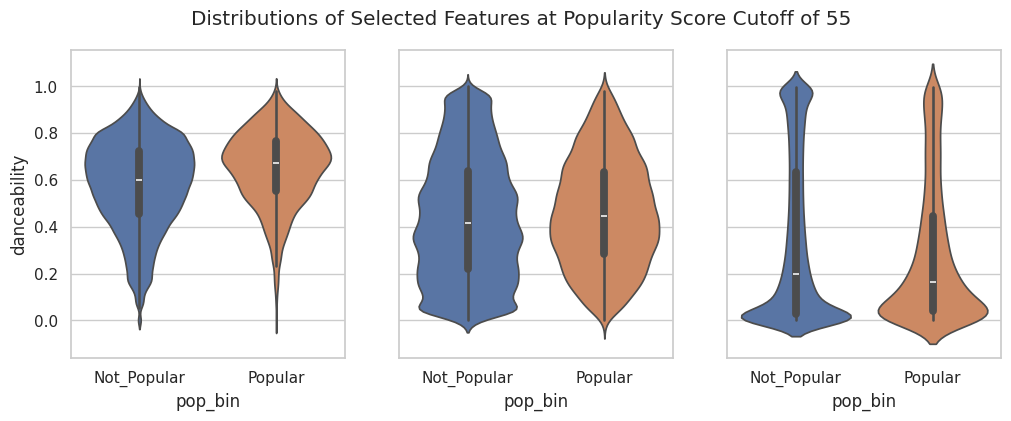

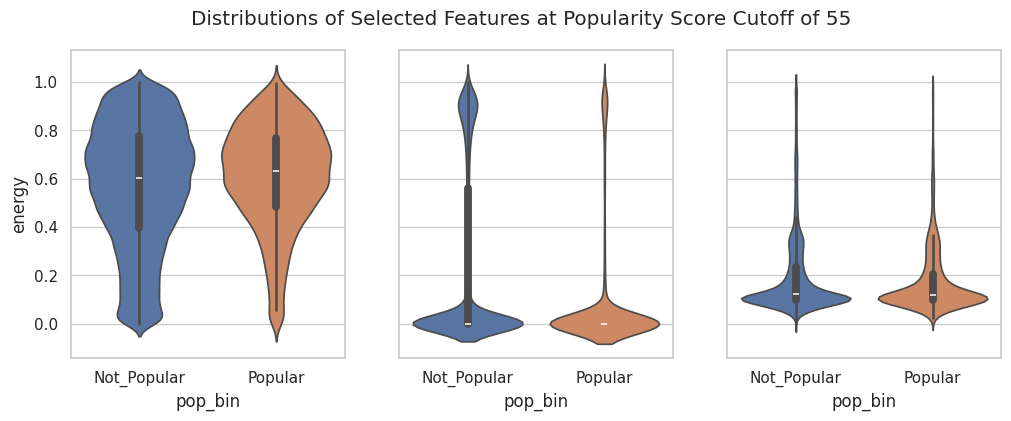

In [ ]:
cutoff = 55
sns.set(style="whitegrid")
df['pop_bin'] = np.where(df['popularity'] > cutoff, "Popular", "Not_Popular")

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,4))
fig.suptitle('Distributions of Selected Features at Popularity Score Cutoff of 55')

sns.violinplot(x=df['pop_bin'], y=df['danceability'], ax=ax[0], data=df, hue='pop_bin')
sns.violinplot(x=df['pop_bin'], y=df['valence'], ax=ax[1], data=df, hue='pop_bin')
sns.violinplot(x=df['pop_bin'], y=df['acousticness'], ax=ax[2], data=df, hue='pop_bin')

plt.show()

sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,4))
fig.suptitle('Distributions of Selected Features at Popularity Score Cutoff of 55')

sns.violinplot(x=df['pop_bin'], y=df['energy'], ax=ax[0], data=df, hue='pop_bin')
sns.violinplot(x=df['pop_bin'], y=df['instrumentalness'], ax=ax[1], data=df, hue='pop_bin')
sns.violinplot(x=df['pop_bin'], y=df['liveness'], ax=ax[2], data=df, hue='pop_bin')

plt.show()

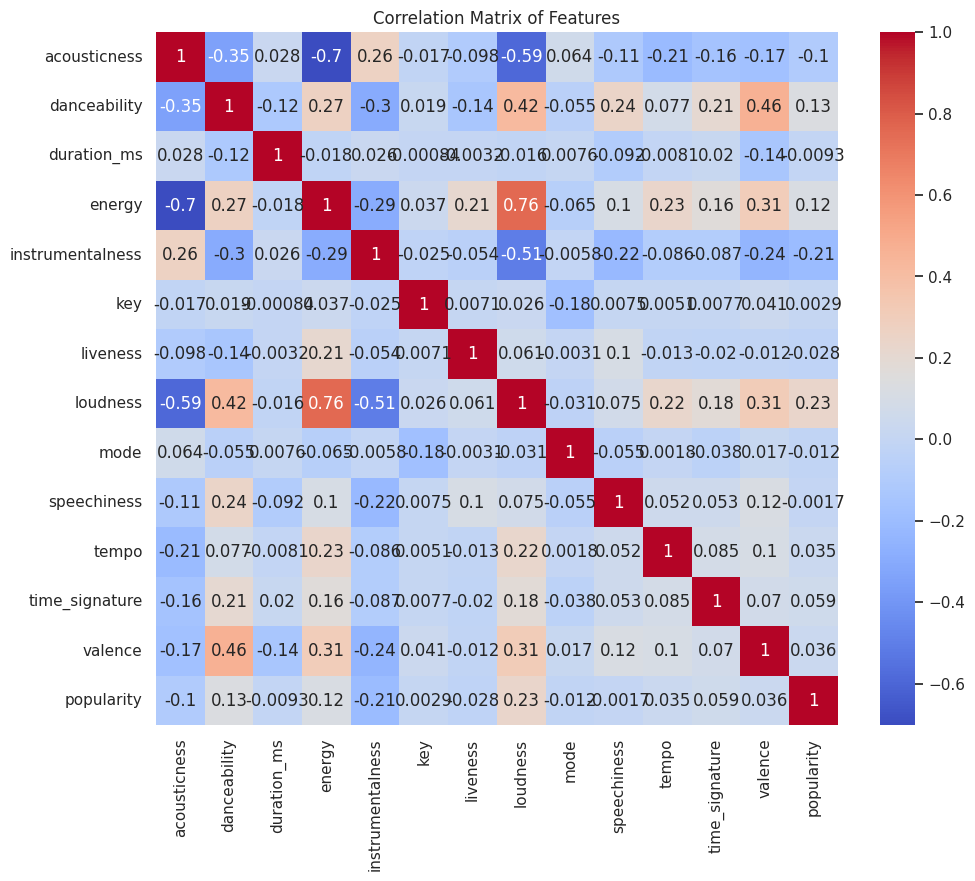

In [ ]:
numerical_features = df.select_dtypes(include=["int64", "float64"])
corr = numerical_features.corr()

# Create a heatmap
plt.figure(figsize=(11,9))
sns.heatmap(corr, annot=True, cmap="coolwarm")

# Add a title
plt.title("Correlation Matrix of Features")

# Show the plot
plt.show()

Scatter plots of few features v/s popularity

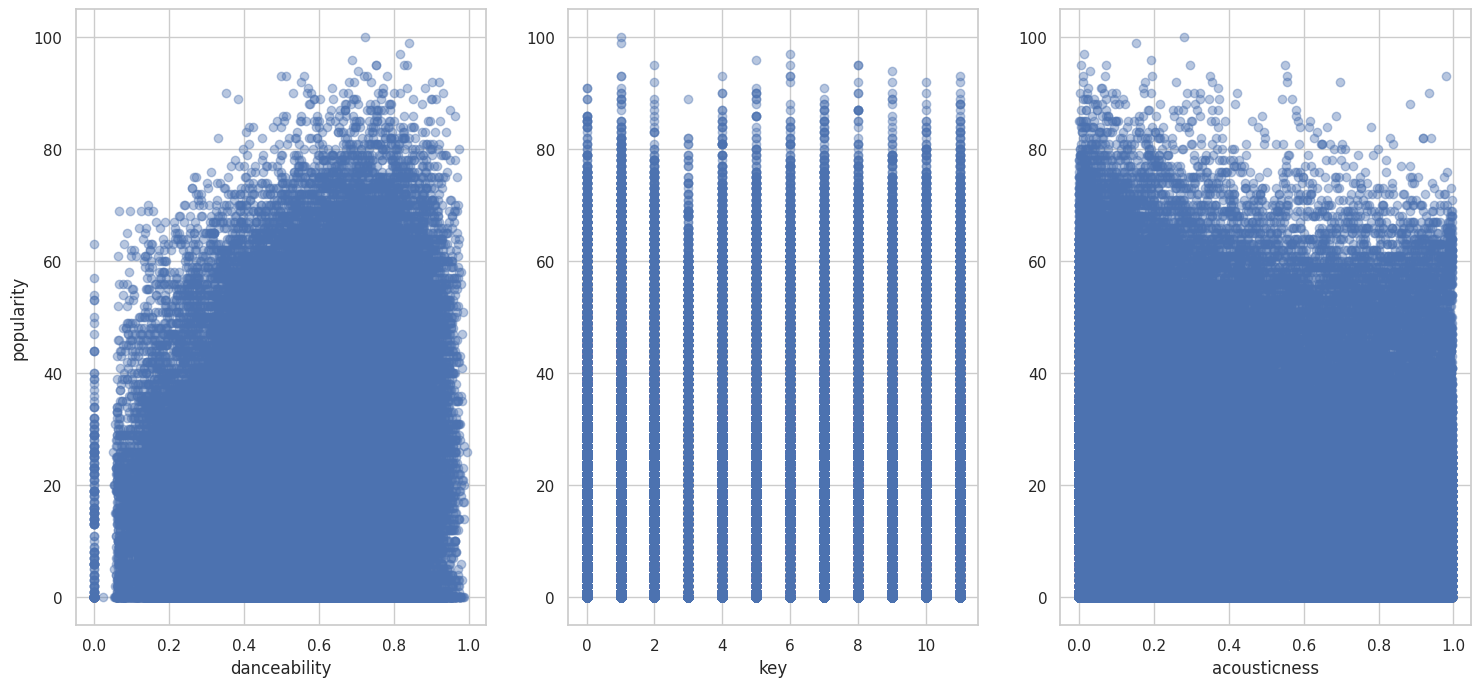

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].scatter(df['danceability'], df['popularity'], alpha=0.4)
axes[1].scatter(df['key'], df['popularity'], alpha=0.4)
axes[2].scatter(df['acousticness'], df['popularity'], alpha=0.4)
axes[0].set_ylabel("popularity")
axes[0].set_xlabel("danceability")
axes[1].set_xlabel("key")
axes[2].set_xlabel("acousticness")
plt.show()

**Step-1: Multiple Linear Regression**

In [ ]:
class MultipleLinearRegression:
    def __init__(self):
        # Coefficients of the linear regression model
        self.intercept = None  # Intercept
        self.coefficients = None  # Coefficients for independent variables

        # Mean values of independent and dependent variables
        self.x_means = None  # Mean values of independent variables
        self.y_mean = None  # Mean value of dependent variable

        # Residuals (errors) of the model
        self.residuals = None

        # Sum of squared errors and total sum of squares
        self.sse = None  # Sum of squared errors
        self.sst = None  # Total sum of squares

        # R-squared and adjusted R-squared values
        self.r_squared = None
        self.r_squared_adj = None

        # Confidence intervals for coefficients and sigma
        self.confidence_intervals = None  # Confidence intervals for coefficients
        self.sigma_estimate = None  # Estimate of sigma
        self.confidence_interval_sigma = None  # Confidence interval for sigma

    def fit(self, X, y):
        n = len(y)
        p = X.shape[1]  # Number of independent variables
        self.x_means = np.mean(X, axis=0)
        self.y_mean = np.mean(y)

        X_centered = X
        self.X = X
        self.y = y

        # Compute coefficients using normal equation
        XTX_inv = np.linalg.inv(np.dot(X_centered.T, X_centered))
        beta = np.dot(np.dot(XTX_inv, X_centered.T), y)
        # print(beta.shape)
        self.intercept = self.y_mean - np.dot(self.x_means, beta)
        self.coefficients = beta

        # Calculate residuals
        y_pred = np.dot(X, beta) + self.intercept
        self.residuals = y - y_pred

        # Compute sum of squared errors and total sum of squares
        self.sse = np.sum(self.residuals ** 2)
        self.sst = np.sum((y - self.y_mean) ** 2)

        # Compute R-squared and adjusted R-squared
        self.r_squared = 1 - (self.sse / self.sst)
        self.r_squared_adj = 1 - ((1 - self.r_squared) * (n - 1) / (n - p - 1))

        # Calculate standard error of the residuals
        self.sigma_estimate = math.sqrt(self.sse / (n - p - 1))

        # Calculate confidence intervals for coefficients
        beta_std_errors = np.sqrt(np.diagonal(self.sigma_estimate**2 * XTX_inv))
        t_critical = stats.t.ppf(1 - 0.025, df=n - p - 1)  # for 95% confidence interval
        confidence_intervals = [(beta[i] - t_critical * beta_std_errors[i],
                                 beta[i] + t_critical * beta_std_errors[i])
                                 for i in range(len(beta))]
        self.confidence_intervals = confidence_intervals

        # Calculate confidence interval for sigma
        self.confidence_interval_sigma = (self.sigma_estimate * math.sqrt(stats.chi2.ppf(0.025, df=n - p - 1)),
                                          self.sigma_estimate * math.sqrt(stats.chi2.ppf(0.975, df=n - p - 1)))

    def significance_test(self, alpha=0.05):
        n = len(self.residuals)
        p = len(self.coefficients)
        df = n - p - 1
        X = self.X
        y = self.y
        # Calculate t-statistics for coefficients
        a1 = np.linalg.inv(np.dot(X.T, X))
        a2 = self.coefficients
        t_stats = self.coefficients / (self.sigma_estimate * np.sqrt(np.diagonal(np.linalg.inv(np.dot(X.T, X)))))

        # Calculate p-values
        p_values = 2 * (1 - stats.t.cdf(abs(t_stats), df))

        # Determine significance
        significant_coeffs = [p_value < alpha for p_value in p_values]

        return {'significant_coeffs': significant_coeffs}

    def anova_test(self, alpha=0.05):
        dof_regression = len(self.coefficients)
        dof_residuals = len(self.residuals) - len(self.coefficients) - 1
        sse = self.sse
        ssr = self.sst - self.sse

        # Compute mean square regression and mean square residuals
        msr = ssr / dof_regression
        mse = sse / dof_residuals

        # Compute F-statistic
        f_statistic = msr / mse

        # Compute p-value
        p_value = stats.f.sf(f_statistic, dof_regression, dof_residuals)

        # Null hypothesis: All regression coefficients are zero
        # Alternative hypothesis: At least one regression coefficient is non-zero
        if p_value < alpha:
            conclusion = "Reject the null hypothesis. At least one regression coefficient is non-zero."
        else:
            conclusion = "Fail to reject the null hypothesis. There is insufficient evidence to conclude that any regression coefficient is non-zero."

        return {
            'f_statistic': f_statistic,
            'p_value': p_value,
            'conclusion': conclusion
        }

    def plot_actual_vs_predicted(self, X_test, y_test):
        # Predict using the fitted model
        y_pred = np.dot(X_test, self.coefficients) + self.intercept

        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.plot(range(len(y_pred)), y_test, color='gray', label='Actual')
        plt.plot(range(len(y_pred)), y_pred, color='orange', label='Predicted')
        plt.title('Actual vs Predicted')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

    def get_summary(self):
        return {
            'intercept': self.intercept,
            'coefficients': self.coefficients,
            'r_squared': self.r_squared,
            'r_squared_adj': self.r_squared_adj,
            'sse': self.sse,
            'sst': self.sst,
            'confidence_intervals': self.confidence_intervals,
            'sigma_estimate': self.sigma_estimate,
            'confidence_interval_sigma': self.confidence_interval_sigma
        }

Train-Test Split of the Cleaned Data

In [4]:
df = pd.read_csv("cleaned_data.csv")

numerical_features = df.select_dtypes(include=["int64", "float64"])
numerical_features.fillna(0, inplace=True)
numerical_features.drop("popularity", axis=1, inplace=True)
y = df["popularity"]
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.20, random_state=625)

Multiple Linear Regression on Train Dataset

In [ ]:
mlr = MultipleLinearRegression()
mlr.fit(X = X_train, y = y_train)

In [ ]:
# Get summary
summary = mlr.get_summary()
print("Intercept:", summary['intercept'])
print("Coefficients:", summary['coefficients'])
print("R-squared:", summary['r_squared'])
print("Adjusted R-squared:", summary['r_squared_adj'])
print("Sum of squared errors (SSE):", summary['sse'])
print("Total sum of squares (SST):", summary['sst'])
print("Confidence intervals for coefficients:")
for i, interval in enumerate(summary['confidence_intervals']):
    print(f"Coefficient {i+1}: {interval}")
print("Estimate of sigma:", summary['sigma_estimate'])
print("Confidence interval for sigma:", summary['confidence_interval_sigma'])

Intercept: 0.2207844873931748
Coefficients: [ 5.51522284e+00  1.21694240e+01  1.55678848e-06  5.17980403e+00
 -6.62378740e+00  8.90490050e-02 -6.52387678e-01  2.63882655e-01
  6.15073316e-01 -7.52092902e+00  2.95151036e-02  3.80450663e+00
 -5.32954316e+00]
R-squared: 0.054543293972638573
Adjusted R-squared: 0.054411045191963714
Sum of squared errors (SSE): 28069393.84633275
Total sum of squares (SST): 29688714.107571654
Confidence intervals for coefficients:
Coefficient 1: (5.067455745167295, 5.962989937678384)
Coefficient 2: (11.450156429440304, 12.888691486192991)
Coefficient 3: (6.775928648687785e-07, 2.4359840947721965e-06)
Coefficient 4: (4.464294361873722, 5.895313705115735)
Coefficient 5: (-6.996824196766987, -6.25075059946905)
Coefficient 6: (0.057767497719090594, 0.12033051220889951)
Coefficient 7: (-1.3599821680300135, 0.05520681168644004)
Coefficient 8: (0.23661752988278262, 0.29114777989276264)
Coefficient 9: (0.38422505629365394, 0.8459215757455287)
Coefficient 10: (-8.482

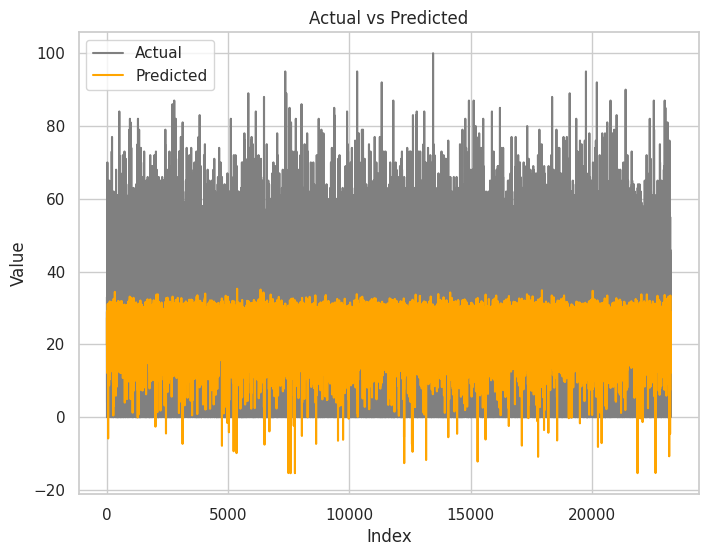

In [ ]:
mlr.plot_actual_vs_predicted(X_test, y_test)

Dropping Data with Popularity value of 0

In [ ]:
# Drop rows where y_train is 0
X_dropped = X_train[y_train != 0]
y_dropped = y_train[y_train != 0]

Multiple Linear Regression on Modified Train Dataset

In [ ]:
mlr = MultipleLinearRegression()
mlr.fit(X = X_dropped, y = y_dropped)

In [ ]:
# Get summary
summary = mlr.get_summary()
print("Intercept:", summary['intercept'])
print("Coefficients:", summary['coefficients'])
print("R-squared:", summary['r_squared'])
print("Adjusted R-squared:", summary['r_squared_adj'])
print("Sum of squared errors (SSE):", summary['sse'])
print("Total sum of squares (SST):", summary['sst'])
print("Confidence intervals for coefficients:")
for i, interval in enumerate(summary['confidence_intervals']):
    print(f"Coefficient {i+1}: {interval}")
print("Estimate of sigma:", summary['sigma_estimate'])
print("Confidence interval for sigma:", summary['confidence_interval_sigma'])

Intercept: 0.21207776345519136
Coefficients: [ 4.98160687e+00  1.60118581e+01 -1.18743342e-06  5.69506709e+00
 -4.26987599e+00  1.03725641e-01 -7.52763611e-01  2.34145677e-01
  6.42491662e-01 -6.47228887e+00  3.19348055e-02  3.67150914e+00
 -5.35573260e+00]
R-squared: 0.05320190697958238
Adjusted R-squared: 0.05305489215421666
Sum of squared errors (SSE): 22468531.312419888
Total sum of squares (SST): 23731069.462489247
Confidence intervals for coefficients:
Coefficient 1: (4.525679070265303, 5.437534668652024)
Coefficient 2: (15.295554971817081, 16.728161271844886)
Coefficient 3: (-2.094414466154891e-06, -2.804523680981002e-07)
Coefficient 4: (4.962554675076554, 6.42757951328079)
Coefficient 5: (-4.652190674386706, -3.8875613121048542)
Coefficient 6: (0.07264406917810282, 0.13480721269910362)
Coefficient 7: (-1.4555344037705185, -0.04999281920455001)
Coefficient 8: (0.20633530639718764, 0.2619560483759831)
Coefficient 9: (0.41307227230438437, 0.8719110522000247)
Coefficient 10: (-7.43

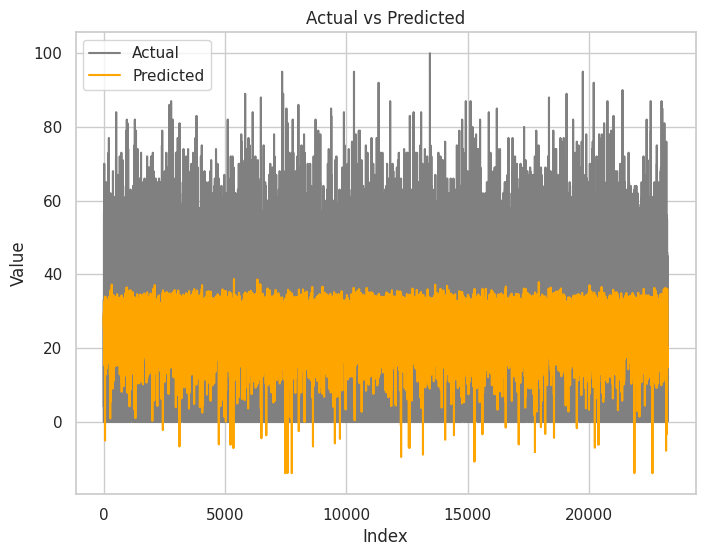

In [ ]:
mlr.plot_actual_vs_predicted(X_test, y_test)

**Simple Linear Regression**

In [ ]:
import numpy as np
import math
from scipy import stats

class SimpleLinearRegression:
    def __init__(self):
        # Coefficients of the linear regression model
        self.b0 = None  # Intercept
        self.b1 = None  # Slope

        # Mean values of independent and dependent variables
        self.x_mean = None
        self.y_mean = None

        # Residuals (errors) of the model
        self.residuals = None

        # Sum of squared errors and total sum of squares
        self.sse = None  # Sum of squared errors
        self.sst = None  # Total sum of squares

        # R-squared and adjusted R-squared values
        self.r_squared = None
        self.r_squared_adj = None

        # Confidence intervals for coefficients (b0 and b1) and sigma
        self.confidence_interval_b0 = None
        self.confidence_interval_b1 = None
        self.sigma_estimate = None
        self.confidence_interval_sigma = None

    def fit(self, x, y):
        n = len(x)
        self.x_mean = np.mean(x)
        self.y_mean = np.mean(y)

        numerator = np.sum((x - self.x_mean) * (y - self.y_mean))
        denominator = np.sum((x - self.x_mean) ** 2)

        self.b1 = numerator / denominator
        self.b0 = self.y_mean - self.b1 * self.x_mean

        self.residuals = y - (self.b0 + self.b1 * x)
        self.sse = np.sum(self.residuals ** 2)
        self.sst = np.sum((y - self.y_mean) ** 2)
        self.r_squared = 1 - (self.sse / self.sst)
        self.r_squared_adj = 1 - ((1 - self.r_squared) * (n - 1) / (n - 2))

        se_b0 = math.sqrt(self.sse / (n - 2)) * math.sqrt((1 / n) + (self.x_mean ** 2) / (np.sum((x - self.x_mean) ** 2)))
        se_b1 = math.sqrt(self.sse / (n - 2)) / math.sqrt(np.sum((x - self.x_mean) ** 2))
        t_critical = stats.t.ppf(1 - 0.025, df=n - 2) # for 95% confidence interval

        self.confidence_interval_b0 = (self.b0 - t_critical * se_b0, self.b0 + t_critical * se_b0)
        self.confidence_interval_b1 = (self.b1 - t_critical * se_b1, self.b1 + t_critical * se_b1)

        self.sigma_estimate = math.sqrt(self.sse / (n - 2))
        self.confidence_interval_sigma = (self.sigma_estimate * math.sqrt(stats.chi2.ppf(0.025, df=n - 2)),
                                          self.sigma_estimate * math.sqrt(stats.chi2.ppf(0.975, df=n - 2)))

    def significance_test(self, alpha=0.05):
        n = len(self.residuals)
        df = n - 2

        # Calculate t-statistic for b0 and b1
        t_stat_b0 = self.b0 / (math.sqrt(self.sse / (n * np.var(self.residuals))))
        t_stat_b1 = self.b1 / (math.sqrt(self.sse / (n * np.var(self.residuals))))

        # Calculate p-value
        p_value_b0 = 2 * (1 - stats.t.cdf(abs(t_stat_b0), df))
        p_value_b1 = 2 * (1 - stats.t.cdf(abs(t_stat_b1), df))

        # Determine significance
        b0_significant = p_value_b0 < alpha
        b1_significant = p_value_b1 < alpha

        return {'b0_significant': b0_significant, 'b1_significant': b1_significant}

    def plot_actual_vs_predicted(self, X_test, y_test):
        # Predict using the fitted model
        y_pred = self.b0 + self.b1 * X_test

        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(X_test, y_test, color='gray', label='Actual')  # Plot actual points
        plt.plot(X_test, y_pred, color='orange', label='Predicted')  # Plot regression line
        plt.title('Actual vs Predicted')
        plt.xlabel('X_test')
        plt.ylabel('y_test')
        plt.legend()
        plt.show()

    def get_summary(self):
        return {
            'b0': self.b0,
            'b1': self.b1,
            'r_squared': self.r_squared,
            'r_squared_adj': self.r_squared_adj,
            'sse': self.sse,
            'sst': self.sst,
            'confidence_interval_b0': self.confidence_interval_b0,
            'confidence_interval_b1': self.confidence_interval_b1,
            'sigma_estimate': self.sigma_estimate,
            'confidence_interval_sigma': self.confidence_interval_sigma
        }

Feature =  acousticness


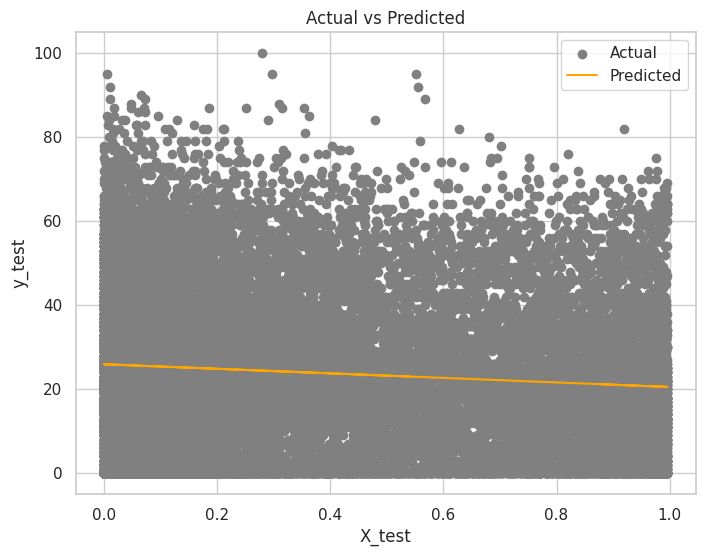


Feature =  danceability


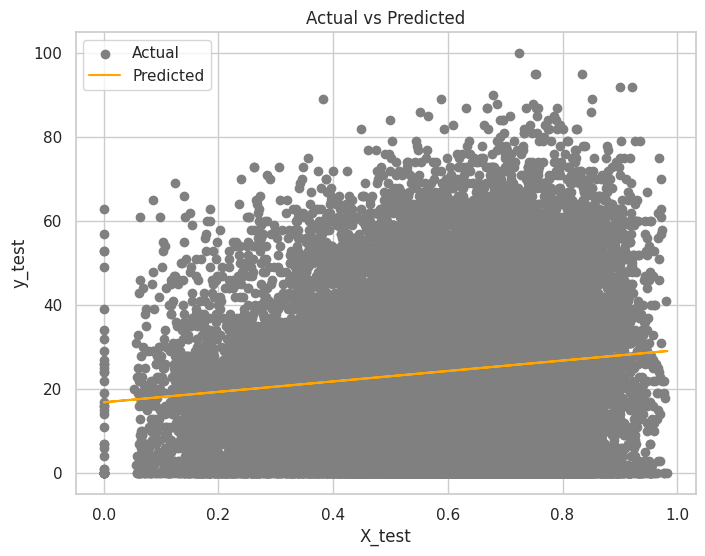


Feature =  duration_ms


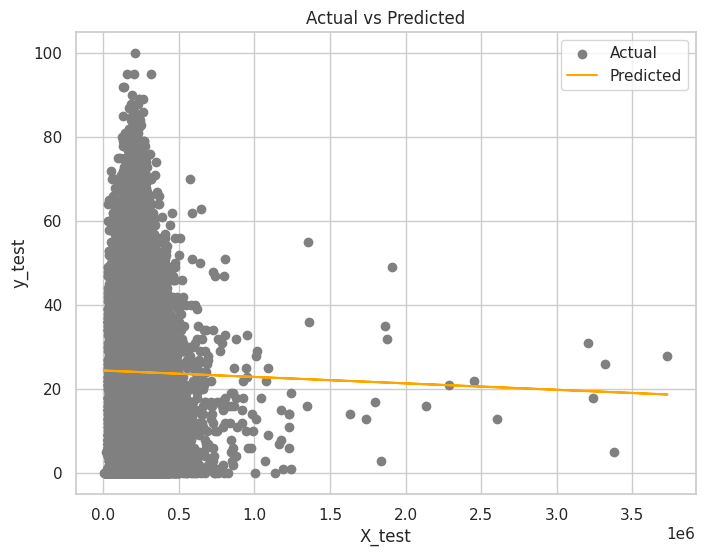


Feature =  energy


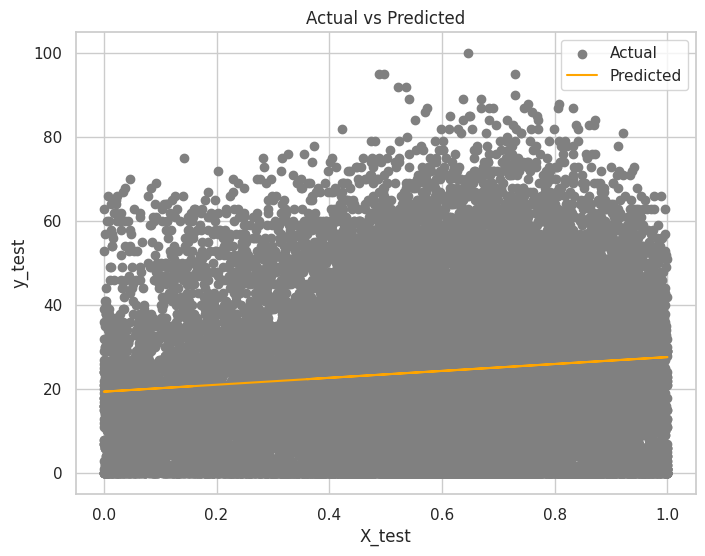


Feature =  instrumentalness


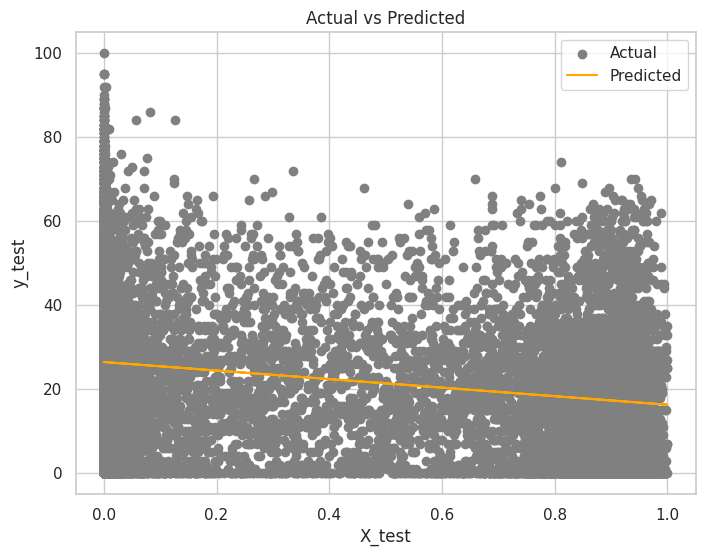


Feature =  key


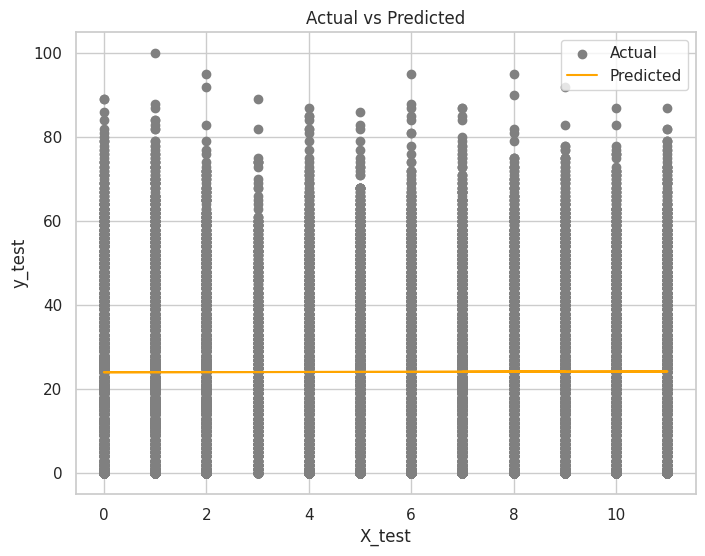


Feature =  liveness


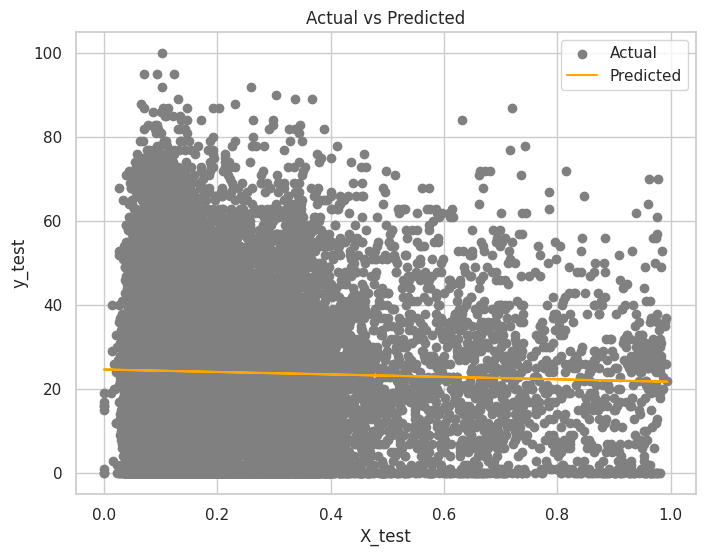


Feature =  loudness


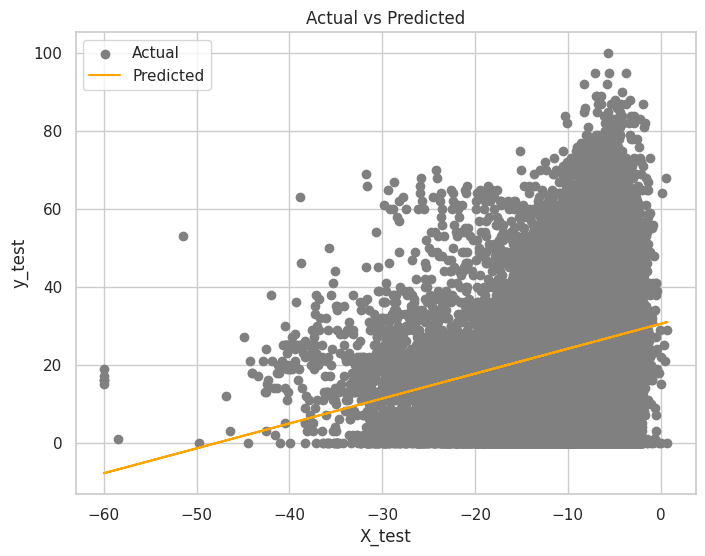


Feature =  mode


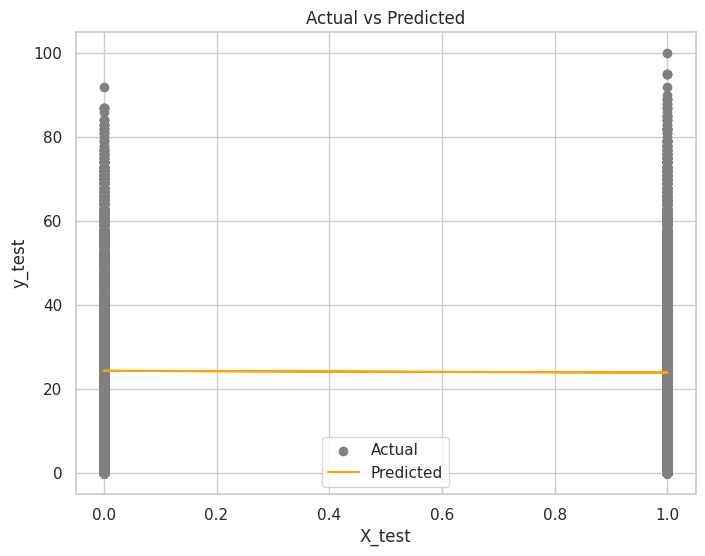


Feature =  speechiness


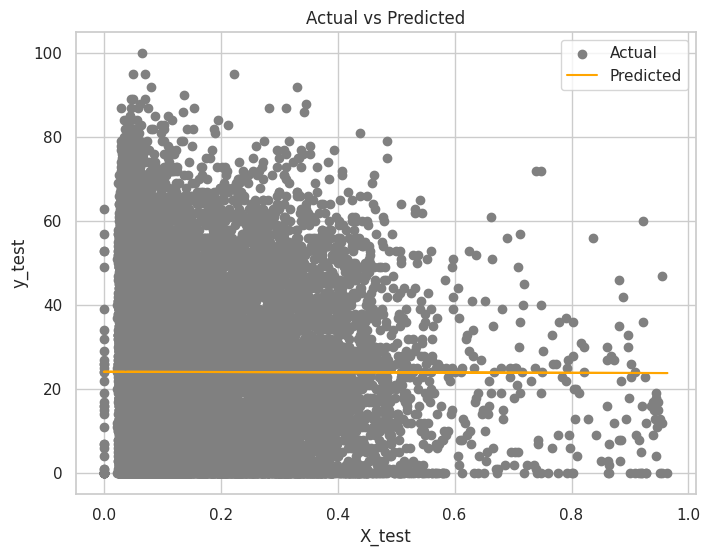


Feature =  tempo


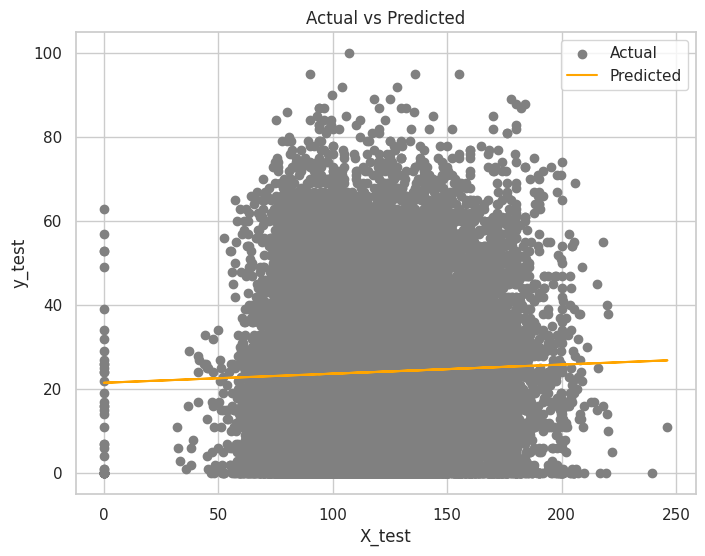


Feature =  time_signature


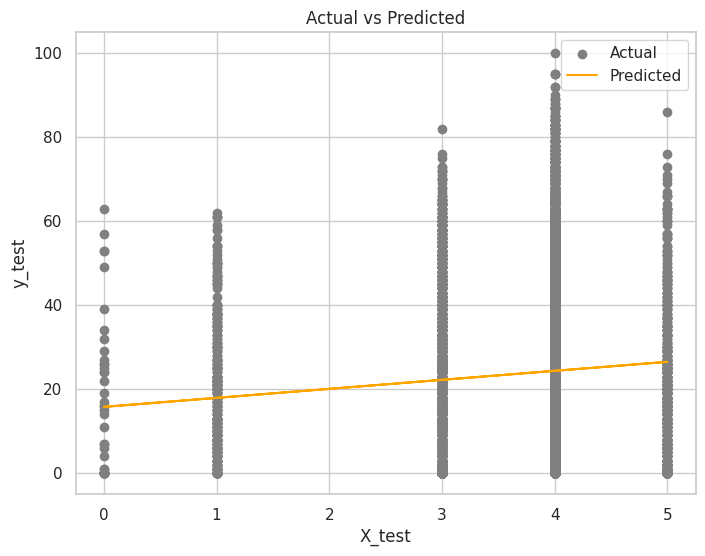


Feature =  valence


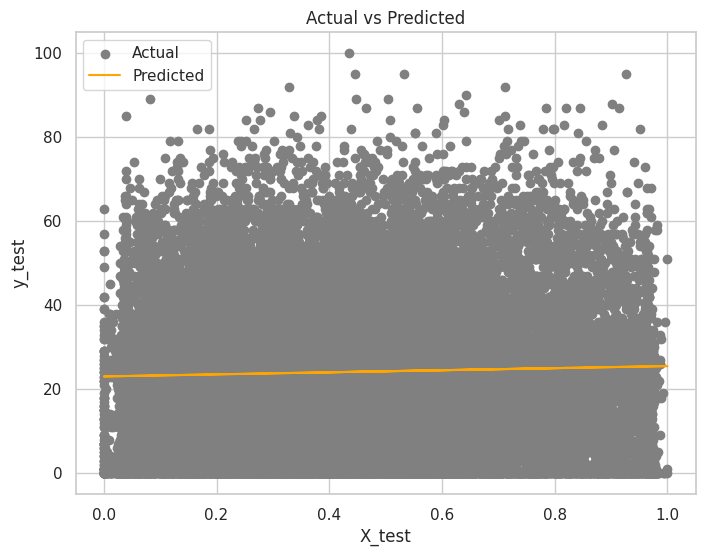


Regression results for acousticness:
b0: 25.952743556672495
b1: -5.413242117393117
r_squared: 0.010822643895031958
r_squared_adj: 0.010812001857849585
sse: 29367403.727083996
sst: 29688714.107571654
confidence_interval_b0: (25.792803889364517, 26.112683223980472)
confidence_interval_b1: (-5.745945257670156, -5.080538977116078)
sigma_estimate: 17.77493739597146
confidence_interval_sigma: (5394.534941103693, 5443.803562524043)

Regression results for danceability:
b0: 16.897111748915265
b1: 12.421013295399716
r_squared: 0.017433760866902404
r_squared_adj: 0.017423189955238838
sse: 29171128.165374417
sst: 29688714.107571654
confidence_interval_b0: (16.529832103082967, 17.264391394747562)
confidence_interval_b1: (11.821537776259325, 13.020488814540107)
sigma_estimate: 17.715438866635143
confidence_interval_sigma: (5376.477668197528, 5425.581371427077)

Regression results for duration_ms:
b0: 24.45706587219119
b1: -1.527566337501665e-06
r_squared: 0.0001186353271960261
r_squared_adj: 0.000

In [ ]:
slr_results = {}

for feature in X_train.columns:
    print("Feature = ",feature)
    slr = SimpleLinearRegression()
    slr.fit(X_train[feature], y_train)
    slr.plot_actual_vs_predicted(X_test[feature], y_test)
    slr_results[feature] = slr.get_summary()
    print()

for feature, summary in slr_results.items():
    print(f"Regression results for {feature}:")
    for key, value in summary.items():
        print(f"{key}: {value}")
    print()

Check for Multicollinearity

In [ ]:
def calculate_r_squared(X, Y):
    # Convert DataFrame/Series to numpy arrays
    X_array = X.to_numpy()
    Y_array = Y.to_numpy()
    # print(X_array)

    # a = np.dot(X_array.T, X_array)
    a = np.dot(X_array.T, X_array)
    b = np.linalg.inv(a)
    c = np.dot(b,X_array.T)
    beta = np.dot(c,Y_array)

    Y_pred = np.dot(X_array, beta)
    Y_mean = np.mean(Y_array)

    SST = np.sum((Y_array - Y_mean)**2)
    SSE = np.sum((Y_array - Y_pred)**2)

    R_squared = 1 - SSE/SST

    return R_squared

In [ ]:
def vif (input_data, i):
  # Extract the i-th feature
  X_i = input_data.iloc[:, i]

  # Extract all other features
  X_other = input_data.drop(input_data.columns[i], axis=1)

  R2 = calculate_r_squared(X_other, X_i)
  ans = 1/(1 - R2)

  return ans

In [ ]:
# Function returns the data with reduced features. Considering the input_data in the format where a feature corresponds to a column.
# Assuming input_data consists of the first column with all values 1 (bias).
def reduced_features(X_train, threshold = 0.9):
  input_data = X_train.copy()
  input_data.insert(0, 'Bias', np.ones(len(input_data)))
  X = input_data.to_numpy()
  corr_df = input_data.iloc[:,1:].corr()
  # corr_df = input_data.corr()
  corr_matrix = corr_df.to_numpy()
  print(corr_df)

  num_features = len(input_data.columns) - 1
  removed_features = []

  for i in range(num_features):
    for j in range(i+1,num_features):
      if i in removed_features or j in removed_features:
        continue
      if corr_matrix[i][j] < threshold:
        continue
      vif_i = vif(input_data,i)
      vif_j = vif(input_data,j)
      if vif_i >= vif_j:
        removed_features.append(i)
      else:
        removed_features.append(j)

  for i in range(len(removed_features)):
    removed_features[i] += 1

  reduced_data = input_data.drop(input_data.columns[removed_features],axis=1)
  return reduced_data

In [ ]:
print(reduced_features(X_train,0.9).info())

                  acousticness  danceability  duration_ms    energy  \
acousticness          1.000000     -0.350092     0.026371 -0.702063   
danceability         -0.350092      1.000000    -0.114952  0.272288   
duration_ms           0.026371     -0.114952     1.000000 -0.016023   
energy               -0.702063      0.272288    -0.016023  1.000000   
instrumentalness      0.265139     -0.297963     0.026835 -0.290394   
key                  -0.018611      0.018216    -0.001669  0.039514   
liveness             -0.098744     -0.139433    -0.001711  0.212081   
loudness             -0.595434      0.419430    -0.014527  0.761059   
mode                  0.065210     -0.056492     0.006427 -0.065412   
speechiness          -0.114303      0.244354    -0.087782  0.104742   
tempo                -0.212961      0.078274    -0.007023  0.228745   
time_signature       -0.162180      0.207156     0.019599  0.163995   
valence              -0.176624      0.463296    -0.135484  0.305181   

     

Principal Component Regression on Training Dataset

In [ ]:
class PrincipalComponentRegression:
    def __init__(self, barrier=0.85):
        self.n_components = None
        self.threshold = barrier
        self.mean = None
        self.components = None
        self.beta = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.mean = None
        self.maximums = None

    def fit(self, X, y):
        # Step 1: Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        self.maximums = np.max(np.abs(X_centered), axis = 0)
        X_centered = X_centered / self.maximums
        # print(self.maximums)

        # Step 2: Perform PCA
        # covariance_matrix = np.cov(X_centered.T)
        eigenvalues, eigenvectors = np.linalg.eig(X_centered.T@X_centered)
        # print(eigenvalues)

        # print(eigenvectors)
        den = sum(eigenvalues)
        num_comp = 0
        num = 0

        eigenvectors = eigenvectors[np.argsort(eigenvalues)]
        eigenvalues = np.sort(eigenvalues)

        # print(eigenvectors)
        eigenvectors = np.flip(eigenvectors)
        eigenvalues = np.flip(eigenvalues)

        tot = len(eigenvalues)
        for i in range(tot):
            num_comp += 1
            num += eigenvalues[i]
            if num/den >= self.threshold:
              break

        self.n_components = num_comp
        # idx = eigenvalues.argsort()[::-1]
        self.components = eigenvectors[:self.n_components,:]
        # print(self.components)

        self.eigenvectors = eigenvectors
        self.eigenvalues = eigenvalues

        # Step 3: Project data onto principal components
        X_projected = np.dot(X_centered, self.components.T)

        # Step 4: Fit linear regression on projected data
        ones_column = np.ones((X_projected.shape[0], 1))
        X_regression = np.hstack((ones_column, X_projected))
        self.beta = np.linalg.inv(X_regression.T.dot(X_regression)).dot(X_regression.T).dot(y)

    def predict(self, X):
        # Step 1: Center the data
        X_centered = X - self.mean
        X_centered = X_centered / self.maximums
        # Step 2: Project data onto principal components
        X_projected = np.dot(X_centered, self.components.T)

        # Step 3: Predict using linear regression coefficients
        ones_column = np.ones((X_projected.shape[0], 1))
        X_regression = np.hstack((ones_column, X_projected))
        return X_regression.dot(self.beta)

    def plot_actual_vs_predicted(self, X_test, y_test):
        # Predict using the fitted model
        y_pred = self.predict(X_test)

        # Plot actual vs predicted
        plt.figure(figsize=(8, 6))
        plt.plot(range(len(y_pred)), y_test, color='gray', label='Actual')
        plt.plot(range(len(y_pred)), y_pred, color='orange', label='Predicted')
        plt.title('Actual vs Predicted')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

    def show_eigenvectors(self):
        print('Number of reduced components:\n',self.n_components)
        for i in range(len(self.eigenvalues)):
            print(f"Component {i+1}: ")
            print(f"Eigenvalue: {self.eigenvalues[i]}\nEigenvector: {self.eigenvectors[i]}")

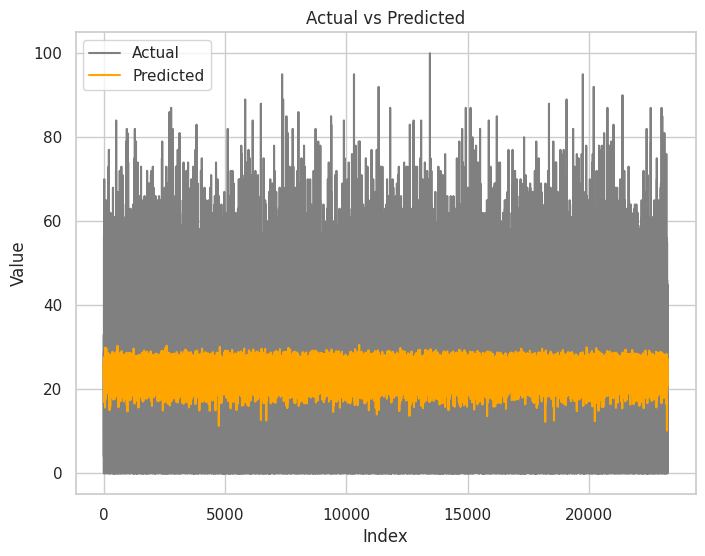

In [ ]:
pcr = PrincipalComponentRegression()

pcr.fit(X_train, y_train)
pcr.plot_actual_vs_predicted(X_test, y_test)

In [ ]:
# Print coefficients
print("Intercept:", pcr.beta[0])
print("Coefficients for principal components:", pcr.beta[1:])

y_pred = pcr.predict(X_test)
SST = np.sum((y_test - np.mean(y_test))**2)
SSE = np.sum((y_test - y_pred)**2)

R_squared = 1 - SSE/SST
print('R-squared value:',R_squared)

Intercept: 24.131971340046476
Coefficients for principal components: [ 0.03618415  9.41074824  4.48843796  0.27837143 -1.58227758]
R-squared value: 0.024272356884876944


In [ ]:
pcr.show_eigenvectors()

Number of reduced components:
 5
Component 1: 
Eigenvalue: 63569.187637432224
Eigenvector: [-3.06587866e-03  4.93197564e-03 -5.72672084e-04 -9.49321493e-04
  3.11304840e-02 -5.88233916e-02 -4.87496012e-01  3.80538970e-01
  3.34488213e-02  4.86134092e-01 -7.64544054e-02 -5.91624408e-01
  1.40583014e-01]
Component 2: 
Eigenvalue: 47395.46236837412
Eigenvector: [-0.13579409  0.10556664 -0.07622784  0.00554241 -0.21843992  0.03349696
 -0.59513546 -0.64746257 -0.1420209   0.24690188  0.01285647  0.23986501
 -0.05925547]
Component 3: 
Eigenvalue: 33895.335333235475
Eigenvector: [-1.01858640e-02 -6.76733605e-03  6.73429514e-03  9.99853918e-01
  5.49344663e-03 -1.20529255e-03 -6.70177032e-04  3.71419874e-03
  4.45646123e-03 -5.16376458e-03  4.35705685e-05 -2.14916486e-03
  4.71034408e-04]
Component 4: 
Eigenvalue: 20131.443095186867
Eigenvector: [ 0.05622041  0.03606315 -0.18568691 -0.00103252  0.18751189  0.04858445
 -0.50922043  0.54660461 -0.10546394 -0.2691106   0.03922573  0.51498253
 -0.

Principal Component Regression removing the "mode" feature

In [ ]:
X_train_new = X_train.drop('mode', axis=1)
X_test_new = X_test.drop('mode', axis=1)

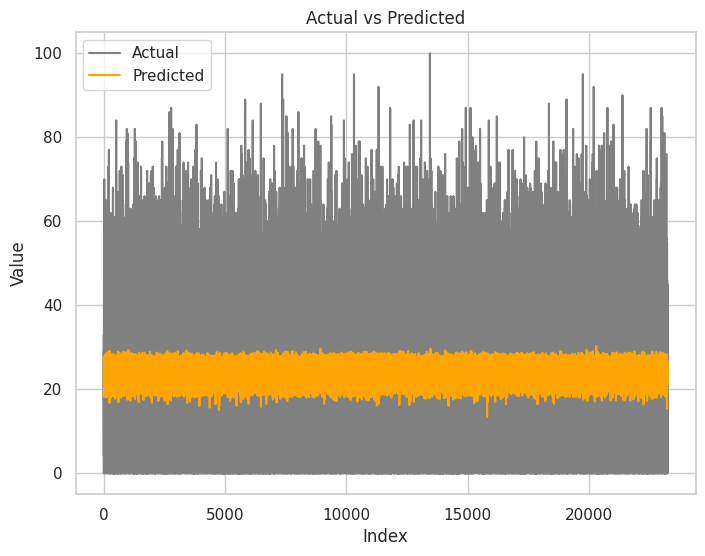

In [ ]:
pcr = PrincipalComponentRegression()

pcr.fit(X_train_new, y_train)
pcr.plot_actual_vs_predicted(X_test_new, y_test)

In [ ]:
# Print coefficients
print("Intercept:", pcr.beta[0])
print("Coefficients for principal components:", pcr.beta[1:])

y_pred = pcr.predict(X_test_new)
SST = np.sum((y_test - np.mean(y_test))**2)
SSE = np.sum((y_test - y_pred)**2)

R_squared = 1 - SSE/SST
print('R-squared value:',R_squared)

Intercept: 24.13197134004648
Coefficients for principal components: [ 5.03957604 -3.48969047  5.53590927  7.45500511 -0.77691701]
R-squared value: 0.020343717201810607


In [ ]:
pcr.show_eigenvectors()

Number of reduced components:
 5
Component 1: 
Eigenvalue: 48271.101691452124
Eigenvector: [ 0.00311145  0.00490159 -0.00063067 -0.00095278 -0.03152887 -0.06682688
 -0.49038913 -0.37561345 -0.03210115 -0.48510477  0.10809794 -0.60406608]
Component 2: 
Eigenvalue: 36230.430558513406
Eigenvector: [ 0.1385429   0.10555923 -0.07590302  0.00556226  0.21693877  0.02178268
 -0.59249088  0.65154874  0.1431942  -0.24289463 -0.03273122  0.245355  ]
Component 3: 
Eigenvalue: 20268.538848886656
Eigenvector: [ 1.01812111e-02 -6.80925388e-03  6.76780117e-03  9.99853414e-01
 -5.50457425e-03 -1.23212518e-03 -5.98600725e-04 -3.75541283e-03
 -4.47425736e-03  5.12196852e-03  2.30369391e-04 -2.17648185e-03]
Component 4: 
Eigenvalue: 15669.008731123982
Eigenvector: [-0.05513828  0.03667943 -0.18542669 -0.00101277 -0.18830597  0.03951519
 -0.51166222 -0.5451474   0.10454693  0.26720324 -0.07222801  0.52695473]
Component 5: 
Eigenvalue: 8121.623383852228
Eigenvector: [-3.59535589e-02 -1.74182845e-03  7.93294

Undersampling

In [5]:
def underSampling(X_train, y_train, cutoff):
  # Select popular samples where y_train > cutoff
  popular_mask = y_train.values > cutoff
  X_popular = X_train.values[popular_mask]
  y_popular = y_train.values[popular_mask]

  # Select unpopular samples where y_train <= cutoff
  unpopular_mask = y_train.values <= cutoff
  X_unpopular = X_train.values[unpopular_mask]
  y_unpopular = y_train.values[unpopular_mask]

  # Sample unpopular samples to match the size of popular samples
  num_samples = len(X_popular)
  sampled_indices = np.random.choice(len(X_unpopular), size=num_samples, replace=False)
  X_unpopular_sampled = [X_unpopular[indices] for indices in sampled_indices]
  y_unpopular_sampled = [y_unpopular[indices] for indices in sampled_indices]

  # Combine popular and sampled unpopular samples
  X_combined = np.concatenate((X_popular, X_unpopular_sampled), axis=0)
  y_combined = np.concatenate((y_popular, y_unpopular_sampled), axis=0)

  return X_combined, y_combined

Cutoff = 55

In [ ]:
cutoff = 55
X_sample, y_sample = underSampling(X_train, y_train, cutoff)

In [ ]:
mlr = MultipleLinearRegression()
mlr.fit(X = X_sample, y = y_sample)

In [ ]:
# Get summary
summary = mlr.get_summary()
print("Intercept:", summary['intercept'])
print("Coefficients:", summary['coefficients'])
print("R-squared:", summary['r_squared'])
print("Adjusted R-squared:", summary['r_squared_adj'])
print("Sum of squared errors (SSE):", summary['sse'])
print("Total sum of squares (SST):", summary['sst'])
print("Confidence intervals for coefficients:")
for i, interval in enumerate(summary['confidence_intervals']):
    print(f"Coefficient {i+1}: {interval}")
print("Estimate of sigma:", summary['sigma_estimate'])
print("Confidence interval for sigma:", summary['confidence_interval_sigma'])

Intercept: 0.3162721577827412
Coefficients: [ 1.13028994e+01  2.57644598e+01 -4.69536926e-06  1.68457285e-01
 -1.18021694e+01  1.50774634e-01 -4.23270395e+00  8.82605299e-01
  6.04609915e-01 -9.95354082e+00  5.27301998e-02  8.10801146e+00
 -8.93789145e+00]
R-squared: 0.12589214457152864
Adjusted R-squared: 0.12486079567694064
Sum of squared errors (SSE): 5641123.554716252
Total sum of squares (SST): 6453578.376722262
Confidence intervals for coefficients:
Coefficient 1: (9.498781989771345, 13.107016881589441)
Coefficient 2: (22.919143402138513, 28.60977612960686)
Coefficient 3: (-9.209883242741713e-06, -1.808552814968756e-07)
Coefficient 4: (-2.749133200038158, 3.086047769735112)
Coefficient 5: (-13.482981002641505, -10.121357797120517)
Coefficient 6: (0.03242245677589875, 0.2691268102904557)
Coefficient 7: (-7.093817598689428, -1.371590309848759)
Coefficient 8: (0.7604615271126304, 1.0047490703674729)
Coefficient 9: (-0.2667111821228699, 1.4759310114244464)
Coefficient 10: (-13.659565

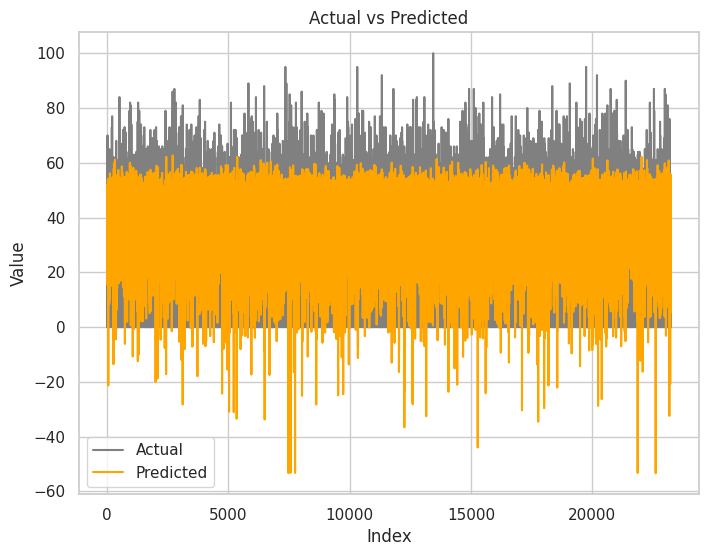

In [ ]:
mlr.plot_actual_vs_predicted(X_test, y_test)

Cutoff = 65

In [ ]:
cutoff = 65
X_sample, y_sample = underSampling(X_train, y_train, cutoff)

In [ ]:
mlr = MultipleLinearRegression()
mlr.fit(X = X_sample, y = y_sample)

In [ ]:
# Get summary
summary = mlr.get_summary()
print("Intercept:", summary['intercept'])
print("Coefficients:", summary['coefficients'])
print("R-squared:", summary['r_squared'])
print("Adjusted R-squared:", summary['r_squared_adj'])
print("Sum of squared errors (SSE):", summary['sse'])
print("Total sum of squares (SST):", summary['sst'])
print("Confidence intervals for coefficients:")
for i, interval in enumerate(summary['confidence_intervals']):
    print(f"Coefficient {i+1}: {interval}")
print("Estimate of sigma:", summary['sigma_estimate'])
print("Confidence interval for sigma:", summary['confidence_interval_sigma'])

Intercept: 0.2913044146588959
Coefficients: [ 8.45318244e+00  3.22464885e+01  3.93166817e-06 -4.02076458e+00
 -2.22561334e+01  1.17896903e-01 -4.83952105e+00  9.94502350e-01
  7.34465326e-01 -7.02706430e+00  5.80343186e-02  9.00515268e+00
 -8.77711579e+00]
R-squared: 0.20256296546487707
Adjusted R-squared: 0.19950675041506682
Sum of squared errors (SSE): 2059028.4209579993
Total sum of squares (SST): 2582057.682031709
Confidence intervals for coefficients:
Coefficient 1: (4.720568186641559, 12.185796689345922)
Coefficient 2: (26.543106611863145, 37.94987048250632)
Coefficient 3: (-5.835433453330065e-06, 1.3698769800371967e-05)
Coefficient 4: (-10.116053704902868, 2.0745245480665107)
Coefficient 5: (-25.77396074374424, -18.738306070982674)
Coefficient 6: (-0.11393966851261435, 0.349733475102557)
Coefficient 7: (-10.73214870762115, 1.0531066082782274)
Coefficient 8: (0.7408974211486641, 1.2481072780349751)
Coefficient 9: (-0.9798318757564488, 2.4487625284747034)
Coefficient 10: (-14.6473

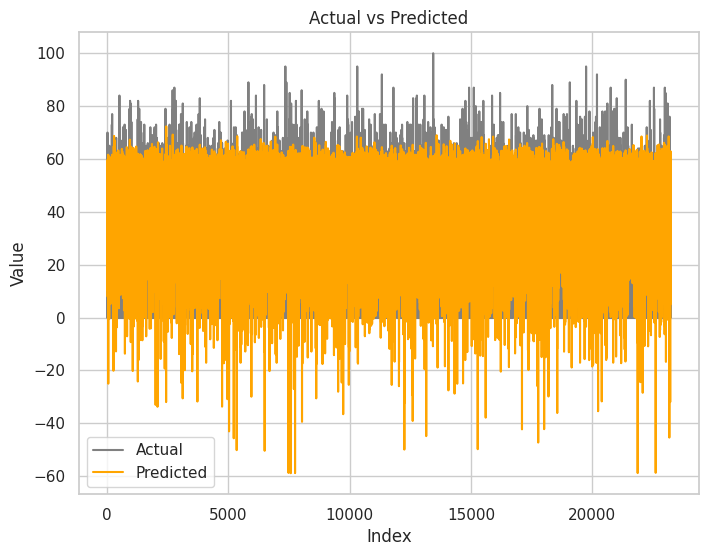

In [ ]:
mlr.plot_actual_vs_predicted(X_test, y_test)

Cutoff = 75

In [ ]:
cutoff = 75
X_sample, y_sample = underSampling(X_train, y_train, cutoff)

In [ ]:
mlr = MultipleLinearRegression()
mlr.fit(X = X_sample, y = y_sample)

In [ ]:
# Get summary
summary = mlr.get_summary()
print("Intercept:", summary['intercept'])
print("Coefficients:", summary['coefficients'])
print("R-squared:", summary['r_squared'])
print("Adjusted R-squared:", summary['r_squared_adj'])
print("Sum of squared errors (SSE):", summary['sse'])
print("Total sum of squares (SST):", summary['sst'])
print("Confidence intervals for coefficients:")
for i, interval in enumerate(summary['confidence_intervals']):
    print(f"Coefficient {i+1}: {interval}")
print("Estimate of sigma:", summary['sigma_estimate'])
print("Confidence interval for sigma:", summary['confidence_interval_sigma'])

Intercept: 0.2014624924740076
Coefficients: [ 8.57291572e+00  5.00501021e+01  2.06498388e-05 -8.80160369e-02
 -3.19114186e+01  1.79711698e-01 -6.88432652e+00  1.17499866e+00
  1.19943811e-01 -1.03753871e+01  6.10998193e-02  7.19293793e+00
 -1.71364175e+01]
R-squared: 0.2996733317197082
Adjusted R-squared: 0.28809032066672635
Sum of squared errors (SSE): 553780.3400559339
Total sum of squares (SST): 790745.7550000001
Confidence intervals for coefficients:
Coefficient 1: (0.33261733499663393, 16.813214111942028)
Coefficient 2: (36.569405320469514, 63.53079887080861)
Coefficient 3: (-5.398228009297005e-06, 4.669790552605684e-05)
Coefficient 4: (-13.753112835914795, 13.577080762170564)
Coefficient 5: (-40.244697815124276, -23.57813935174437)
Coefficient 6: (-0.3518170890820739, 0.7112404845715817)
Coefficient 7: (-20.384758723498734, 6.616105687367325)
Coefficient 8: (0.6008311386428015, 1.749166187231805)
Coefficient 9: (-3.651441557758785, 3.8913291803845755)
Coefficient 10: (-28.8369712

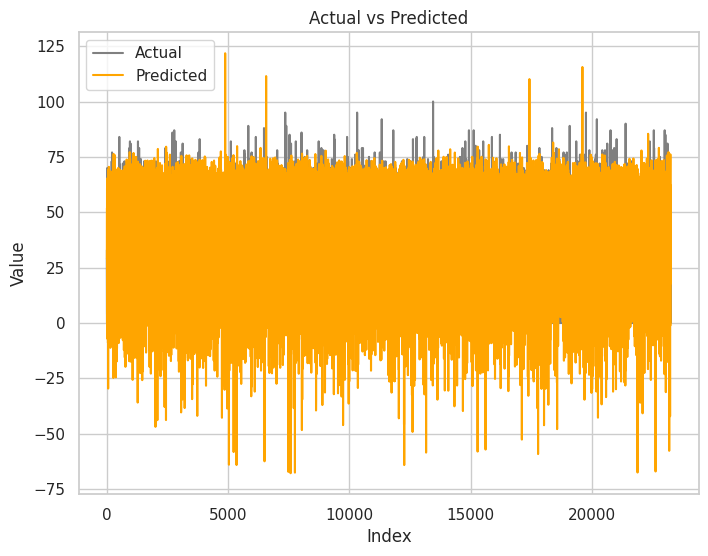

In [ ]:
mlr.plot_actual_vs_predicted(X_test, y_test)

Cutoff = 80

In [ ]:
cutoff = 80
X_sample, y_sample = underSampling(X_train, y_train, cutoff)

In [ ]:
mlr = MultipleLinearRegression()
mlr.fit(X = X_sample, y = y_sample)

In [ ]:
# Get summary
summary = mlr.get_summary()
print("Intercept:", summary['intercept'])
print("Coefficients:", summary['coefficients'])
print("R-squared:", summary['r_squared'])
print("Adjusted R-squared:", summary['r_squared_adj'])
print("Sum of squared errors (SSE):", summary['sse'])
print("Total sum of squares (SST):", summary['sst'])
print("Confidence intervals for coefficients:")
for i, interval in enumerate(summary['confidence_intervals']):
    print(f"Coefficient {i+1}: {interval}")
print("Estimate of sigma:", summary['sigma_estimate'])
print("Confidence interval for sigma:", summary['confidence_interval_sigma'])

Intercept: 0.3222979912665238
Coefficients: [ 2.16761781e+01  8.05415287e+01 -1.31362102e-05 -6.91272548e+00
 -2.98914504e+01  2.19846817e-01 -4.53428199e+00  1.67837835e+00
  2.05251787e+00 -3.75854950e+01  2.19483205e-02  8.42972787e+00
 -2.58107357e+01]
R-squared: 0.4182505029294541
Adjusted R-squared: 0.396265783563416
Sum of squared errors (SSE): 247760.03393346354
Total sum of squares (SST): 425887.83519553073
Confidence intervals for coefficients:
Coefficient 1: (8.856868967259212, 34.49548728198698)
Coefficient 2: (61.180063262172375, 99.9029941712146)
Coefficient 3: (-2.818488048573344e-05, 1.912459987409397e-06)
Coefficient 4: (-26.918670312156834, 13.093219352364756)
Coefficient 5: (-42.247180367679796, -17.53572039953942)
Coefficient 6: (-0.5505408657996065, 0.9902344995022754)
Coefficient 7: (-24.117794283534685, 15.049230311031359)
Coefficient 8: (0.8652769513045947, 2.491479753903831)
Coefficient 9: (-3.771785510771917, 7.876821248020953)
Coefficient 10: (-66.08874170888

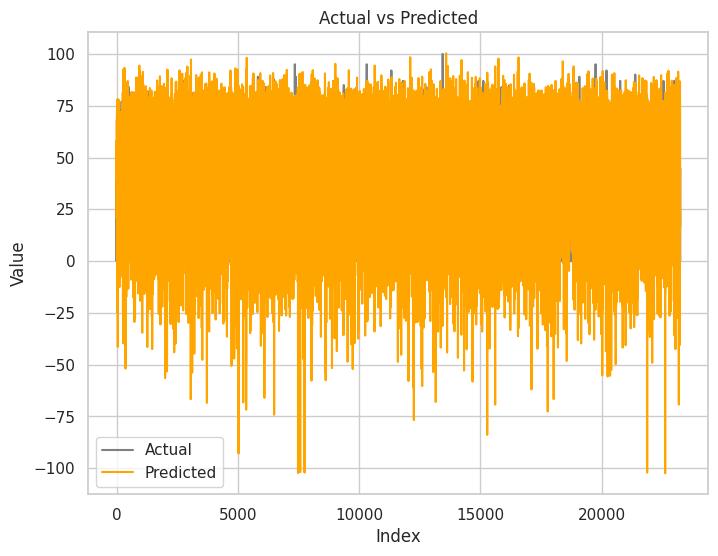

In [ ]:
mlr.plot_actual_vs_predicted(X_test, y_test)

Cutoff = 85

In [ ]:
cutoff = 85
X_sample, y_sample = underSampling(X_train, y_train, cutoff)

In [ ]:
mlr = MultipleLinearRegression()
mlr.fit(X = X_sample, y = y_sample)

In [ ]:
# Get summary
summary = mlr.get_summary()
print("Intercept:", summary['intercept'])
print("Coefficients:", summary['coefficients'])
print("R-squared:", summary['r_squared'])
print("Adjusted R-squared:", summary['r_squared_adj'])
print("Sum of squared errors (SSE):", summary['sse'])
print("Total sum of squares (SST):", summary['sst'])
print("Confidence intervals for coefficients:")
for i, interval in enumerate(summary['confidence_intervals']):
    print(f"Coefficient {i+1}: {interval}")
print("Estimate of sigma:", summary['sigma_estimate'])
print("Confidence interval for sigma:", summary['confidence_interval_sigma'])

Intercept: 0.23440650070794788
Coefficients: [ 1.27952240e+01  5.10713453e+01  4.65106763e-05 -3.27367113e+01
 -1.66266194e+01  4.62977305e-01 -1.62204427e+01  3.70237051e+00
  1.38904418e+00  1.75874128e+01 -8.53105508e-03  1.87970036e+01
 -3.55776223e+01]
R-squared: 0.33683727737299285
Adjusted R-squared: 0.26841572662576196
Sum of squared errors (SSE): 108072.10467034025
Total sum of squares (SST): 162964.6857142857
Confidence intervals for coefficients:
Coefficient 1: (-11.175017483818008, 36.76546556875382)
Coefficient 2: (12.731693333303078, 89.41099735483033)
Coefficient 3: (-2.1443521350986306e-05, 0.00011446487387529422)
Coefficient 4: (-74.46798170869981, 8.99455915694638)
Coefficient 5: (-44.02128235420284, 10.768043650016736)
Coefficient 6: (-1.0444654530611437, 1.9704200626613397)
Coefficient 7: (-56.81325633874441, 24.372370847535162)
Coefficient 8: (1.6502029449632563, 5.754538079052993)
Coefficient 9: (-9.005614241860238, 11.783702602844128)
Coefficient 10: (-32.4199321

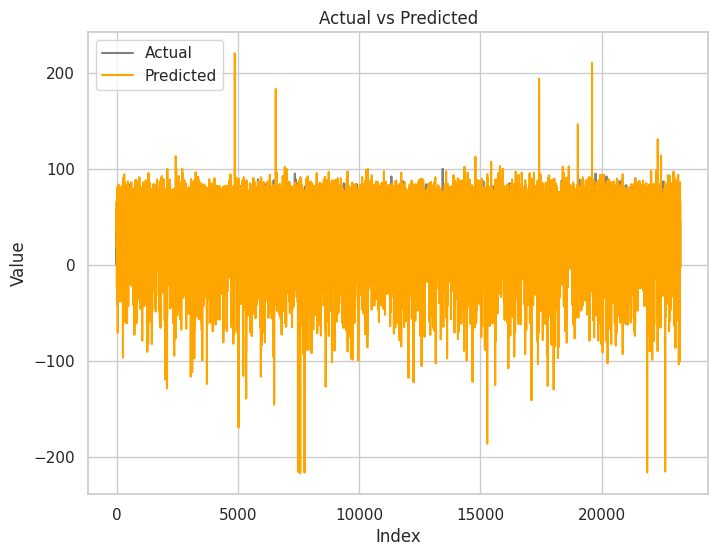

In [ ]:
mlr.plot_actual_vs_predicted(X_test, y_test)

Cutoff = 90

In [ ]:
cutoff = 90
X_sample, y_sample = underSampling(X_train, y_train, cutoff)

In [ ]:
mlr = MultipleLinearRegression()
mlr.fit(X = X_sample, y = y_sample)

In [ ]:
# Get summary
summary = mlr.get_summary()
print("Intercept:", summary['intercept'])
print("Coefficients:", summary['coefficients'])
print("R-squared:", summary['r_squared'])
print("Adjusted R-squared:", summary['r_squared_adj'])
print("Sum of squared errors (SSE):", summary['sse'])
print("Total sum of squares (SST):", summary['sst'])
print("Confidence intervals for coefficients:")
for i, interval in enumerate(summary['confidence_intervals']):
    print(f"Coefficient {i+1}: {interval}")
print("Estimate of sigma:", summary['sigma_estimate'])
print("Confidence interval for sigma:", summary['confidence_interval_sigma'])

Intercept: 0.08644940767067055
Coefficients: [ 2.28984331e+01  7.51898926e+01 -6.44970999e-05 -1.05683119e+02
 -4.25257872e+01  6.50713692e-01 -7.22288465e+01  2.68925645e+00
  1.45377733e+01  1.54993122e+02 -1.92519391e-01  3.17170589e+01
 -1.97138175e+01]
R-squared: 0.5782620052178089
Adjusted R-squared: 0.36739300782671336
Sum of squared errors (SSE): 24229.59638517761
Total sum of squares (SST): 57451.774999999994
Confidence intervals for coefficients:
Coefficient 1: (-27.288127084117313, 73.08499323733344)
Coefficient 2: (8.016057532569448, 142.3637276441517)
Coefficient 3: (-0.000254911281391101, 0.00012591708159473197)
Coefficient 4: (-213.17707397464648, 1.8108353143017695)
Coefficient 5: (-118.16249100679704, 33.110916597292636)
Coefficient 6: (-2.699056111865113, 4.000483495632899)
Coefficient 7: (-186.73034333998146, 42.2726504022729)
Coefficient 8: (-1.3242318650743807, 6.702744766145262)
Coefficient 9: (-10.860344915870604, 39.93589155955022)
Coefficient 10: (-39.534355719

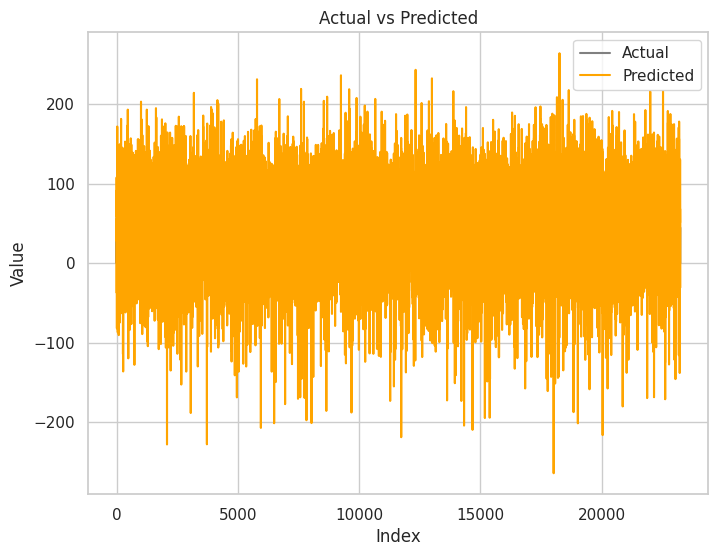

In [ ]:
mlr.plot_actual_vs_predicted(X_test, y_test)

Detection of Outliers for the Final Model

Studentized Residuals

In [ ]:
# Define the value of q
q = 6 # Assuming you want to select the 2nd column, you can change this value as needed

# Selecting the q_th column of X_train
X_centered = X_sample[:1000, q]  # Selecting the q_th column
X_centered = X_centered.reshape(-1, 1)  # Reshape to ensure it's a 2D array
k = 1  # Number of features (since we are using only one feature)
y = y_sample[:1000]

XTX_inv = np.linalg.inv(np.dot(X_centered.T, X_centered))
H = np.matmul(np.matmul(X_centered, XTX_inv), X_centered.T)

n = len(y)
leverage = np.diag(H)

y_mean = np.mean(y)
x_mean = np.mean(X_centered)

data_pt = []
outlier = []
for i in range(n):
    tempX = np.delete(X_centered, i, axis=0)
    tempy = np.delete(y, i)

    temp_y_mean = y_mean * (n - 1)
    temp_x_mean = x_mean * (n - 1)

    temp_y_mean -= y[i]
    temp_x_mean -= X_centered[i]

    XTX_inv = np.linalg.inv(np.dot(tempX.T, tempX))
    beta = np.dot(np.dot(XTX_inv, tempX.T), tempy)
    intercept = temp_y_mean - np.dot(temp_x_mean, beta)

    y_pred = np.dot(X_centered, beta) + intercept
    residuals = y - y_pred

    dof_residuals = n - len(beta) - 1
    mse = np.sum(residuals ** 2) / dof_residuals

    t_statistic = residuals[i] / np.sqrt(mse * (1 - leverage[i]))

    #print(abs(t_statistic))
    if abs(t_statistic) > 1.05:
        outlier.append(i)
    else:
        data_pt.append(i)

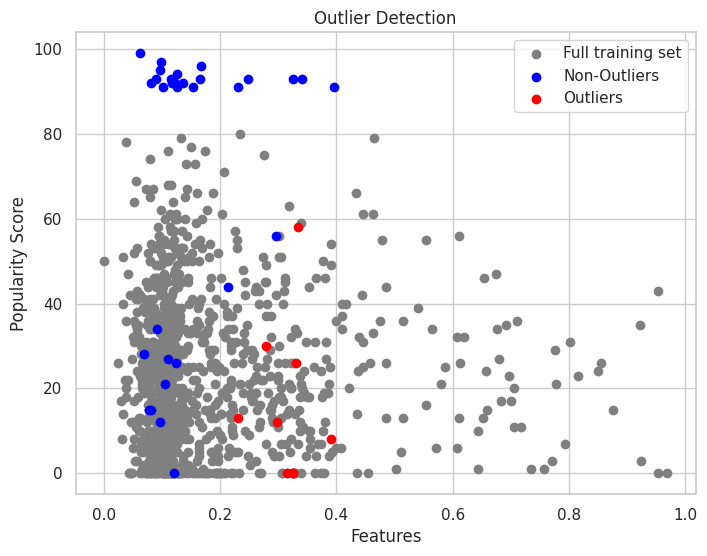

In [ ]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_train.values[:1000, q], y_train.values[:1000], c='gray', label='Full training set')
plt.scatter(X_sample[data_pt, q], y_sample[data_pt], c='blue', label='Non-Outliers')
plt.scatter(X_sample[outlier, q], y_sample[outlier], c='red', label='Outliers')
plt.xlabel('Features')
plt.ylabel('Popularity Score')
plt.title('Outlier Detection')
plt.legend()
plt.show()

JackKnife Method

In [ ]:
import numpy as np
from scipy.stats import t
import math

def jack_knife_test(X, y, outlier_indices=None):
  num_samples = len(X)
  num_features = len(X[0])

  # print(num_samples, num_features)

  beta_hat = np.zeros_like((num_features + 1, num_samples))
  partial_preds = []
  outliers = []
  outlier_idx = []

  # create an object for Multiple Linear Regression - whole and partial

  mlr_whole = MultipleLinearRegression()

  # fitting the model on the whole data

  mlr_whole.fit(X, y)
  summary_whole = mlr_whole.get_summary()
  beta_hat_whole = summary_whole['coefficients'] # shape = (num_features, 1)
  beta_0_whole = summary_whole['intercept'] # shape = (1, 1)
  SSE = summary_whole['sse'] # sum(e[i]^2)

  # calculating the leverage statistic

  hat_matrix = X @ np.linalg.inv(X.T @ X) @ X.T
  hii_matrix = np.diag(hat_matrix)
  # print(hii_matrix)
  # perform MLR by leaving one datapoint out every time
  for i in range(num_samples):
    X_temp = np.delete(X, i, axis=0)
    y_temp = np.delete(y, i)

    # print(X_temp.shape, y_temp.shape)
    mlr_partial = MultipleLinearRegression()
    mlr_partial.fit(X_temp, y_temp)

    summary = mlr_partial.get_summary()
    beta_hat_partial = summary['coefficients'] # num_features number of coefficients
    beta_0_partial = summary['intercept'] # 1 intercept (beta_0)

    error_i_whole = y[i] - (X[i] @ beta_hat_whole + beta_0_whole) # residual from the whole model for the ith datapoint
    yi_pred = (X[i] @ beta_hat_partial + beta_0_partial)
    error_i_partial = y[i] - yi_pred # partial residual for the ith datapoint

    partial_preds.append(yi_pred)

    jack_knife_variance_estimate_statistic = (SSE - (error_i_whole**2/(1-hii_matrix[i])))/(num_samples-num_features-2)

    t_statistic = error_i_partial/(jack_knife_variance_estimate_statistic/(1-hii_matrix[i]))

    # test if the ith datapoint is an outlier or not
    p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df=num_samples - num_features - 2)) # 2-tail test for outlier detection
    #print(p_value)
    # print(error_i_whole, SSE, jack_knife_variance_estimate_statistic, t_statistic, p_value)
    if p_value < 0.95:  # Assuming significance level of 0.5
      outliers.append(X[i])
      outlier_idx.append(i)

  return outliers, outlier_idx

In [ ]:
outliers, outlier_idx = jack_knife_test(X_sample[:1000], y_sample[:1000])

# print("List of possible outliers: ", outliers)
print("Corresponding indices: ", outlier_idx)
print("Number of outliers: ", len(outliers))

Corresponding indices:  [20, 35]
Number of outliers:  2


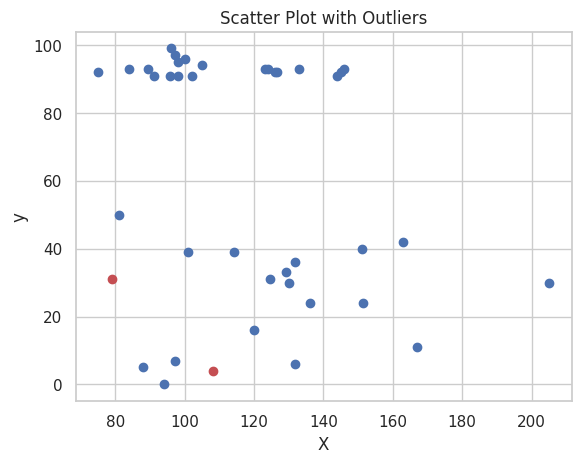

In [ ]:
X2 = X_sample[:1000]
X_ = X2[:, 10]
y = y_sample[:1000]

X_outliers = X_[outlier_idx]
y_outliers = y[outlier_idx]

X_ = np.delete(X_, outlier_idx, axis=0)
y = np.delete(y, outlier_idx, axis=0)

#print(X_.shape, y.shape)

plt.scatter(X_, y, c='b')
plt.scatter(X_outliers, y_outliers, c='r')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Scatter Plot with Outliers')
plt.show()

QQ Plot

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

def qq_plot(data, distribution):
    # Sort data
    data_sorted = np.sort(data)

    # Generate theoretical quantiles from specified distribution
    quantiles = np.arange(0.01, 1, 0.01)
    theoretical_quantiles = stats.distributions.__dict__[distribution].ppf(quantiles)
    #print(theoretical_quantiles)
    #print(data_sorted)

    # Calculate empirical quantiles
    empirical_quantiles = np.percentile(data_sorted, quantiles * 100)

    # Plot Q-Q plot
    plt.figure(figsize=(8, 6))
    plt.scatter(theoretical_quantiles, empirical_quantiles, color='blue', s=30, edgecolor='k')
    plt.title('Q-Q Plot')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid(True)
    plt.show()

In [ ]:
y_test_predict = np.dot(X_test, mlr.coefficients) + mlr.intercept
quantiles_predicted = np.percentile(y_test_predict, np.arange(0, 100))

**Step-2: Logistic Regression**

In [17]:
class LogisticRegression:
    # defining parameters such as learning rate, number ot iterations, whether to include intercept,
    # and verbose which says whether to print anything or not like, loss etc.
    def __init__(self, learning_rate=0.01, num_iterations=1000, fit_intercept=True, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.fit_intercept = fit_intercept
        self.verbose = verbose

    # function to define the Incercept value.
    def __b_intercept(self, X):
        # initially we set it as all 1's
        intercept = np.ones((X.shape[0], 1))
        # then we concatinate them to the value of X, we don't add we just append them at the end.
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid_function(self, z):
        # this is our actual sigmoid function which predicts our yp
        return 1 / (1 + np.exp(-z))

    def __loss(self, yp, y):
        # this is the loss function which we use to minimize the error of our model
        return (-y * np.log(yp) - (1 - y) * np.log(1 - yp)).mean()

    # this is the function which trains our model.
    def fit(self, X, y):

        # as said if we want our intercept term to be added we use fit_intercept=True
        if self.fit_intercept:
            X = self.__b_intercept(X)

        # weights initialization of our Normal Vector, initially we set it to 0, then we learn it eventually
        self.W = np.zeros(X.shape[1])

        # this for loop runs for the number of iterations provided
        for i in range(self.num_iterations):

            # this is our W * Xi
            z = np.dot(X, self.W)

            # this is where we predict the values of Y based on W and Xi
            yp = self.__sigmoid_function(z)

            # this is where the gradient is calculated form the error generated by our model
            gradient = np.dot(X.T, (yp - y)) / y.size

            # this is where we update our values of W, so that we can use the new values for the next iteration
            self.W -= self.learning_rate * gradient

            # this is our new W * Xi
            z = np.dot(X, self.W)
            yp = self.__sigmoid_function(z)

            # this is where the loss is calculated
            loss = self.__loss(yp, y)

            # as mentioned above if we want to print somehting we use verbose, so if verbose=True then our loss get printed
            if(self.verbose ==True and i % 100 == 0):
                print(f'loss: {loss} \t')

    # this is where we predict the probability values based on out generated W values out of all those iterations.
    def predict_prob(self, X):
        # as said if we want our intercept term to be added we use fit_intercept=True
        if self.fit_intercept:
            X = self.__b_intercept(X)

        # this is the final prediction that is generated based on the values learned.
        return self.__sigmoid_function(np.dot(X, self.W))

    # this is where we predict the actual values 0 or 1 using round. anything less than 0.5 = 0 or more than 0.5 is 1
    def predict(self, X):
        return self.predict_prob(X).round()

    def show_weights(self, X):
        n = len(self.W)
        for i in range(n):
            if i:
                print('Coefficient ',i,' : ',X.columns[i-1],' : ',self.W[i])
            else:
                print('Coefficient ',i,' : Bias',' : ',self.W[i])

Importing the Dataset

In [6]:
df = pd.read_csv("SpotifyAudioFeaturesNov2018.csv")
df.drop_duplicates(subset=['track_id'], inplace=True)
df.to_csv('cleaned_data.csv', index=False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 116191 entries, 0 to 116371
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist_name       116191 non-null  object 
 1   track_id          116191 non-null  object 
 2   track_name        116190 non-null  object 
 3   acousticness      116191 non-null  float64
 4   danceability      116191 non-null  float64
 5   duration_ms       116191 non-null  int64  
 6   energy            116191 non-null  float64
 7   instrumentalness  116191 non-null  float64
 8   key               116191 non-null  int64  
 9   liveness          116191 non-null  float64
 10  loudness          116191 non-null  float64
 11  mode              116191 non-null  int64  
 12  speechiness       116191 non-null  float64
 13  tempo             116191 non-null  float64
 14  time_signature    116191 non-null  int64  
 15  valence           116191 non-null  float64
 16  popularity        116191 

Standardized scaling of the features into comparable forms

In [7]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

df = pd.read_csv("cleaned_data.csv")
print(df.info())

numerical_features = df.select_dtypes(include=["int64", "float64"])
numerical_features = pd.DataFrame(scaler.fit_transform(numerical_features), columns=numerical_features.columns)
numerical_features.fillna(0, inplace=True)
numerical_features.drop("popularity", axis=1, inplace=True)
y = df["popularity"]
y.fillna(0, inplace=True)

X_train, X_test, y_train, y_test_ = train_test_split(numerical_features, y, test_size=0.20, random_state=62, shuffle=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116191 entries, 0 to 116190
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist_name       116191 non-null  object 
 1   track_id          116191 non-null  object 
 2   track_name        116190 non-null  object 
 3   acousticness      116191 non-null  float64
 4   danceability      116191 non-null  float64
 5   duration_ms       116191 non-null  int64  
 6   energy            116191 non-null  float64
 7   instrumentalness  116191 non-null  float64
 8   key               116191 non-null  int64  
 9   liveness          116191 non-null  float64
 10  loudness          116191 non-null  float64
 11  mode              116191 non-null  int64  
 12  speechiness       116191 non-null  float64
 13  tempo             116191 non-null  float64
 14  time_signature    116191 non-null  int64  
 15  valence           116191 non-null  float64
 16  popularity        11

Undersampling

In [8]:
def underSampling(X_train, y_train, cutoff):
  # Select popular samples where y_train > cutoff
  popular_mask = y_train.values > cutoff
  X_popular = X_train.values[popular_mask]
  # print(len(X_popular))
  y_popular = [1 for i in range(len(X_popular))]
  # print(len(y_popular))

  # Select unpopular samples where y_train <= cutoff
  unpopular_mask = y_train.values <= cutoff
  X_unpopular = X_train.values[unpopular_mask]
  y_unpopular = y_train.values[unpopular_mask]

  # Sample unpopular samples to match the size of popular samples
  num_samples = len(X_popular)
  sampled_indices = np.random.choice(len(X_unpopular), size=num_samples, replace=False)
  X_unpopular_sampled = [X_unpopular[indices] for indices in sampled_indices]
  # print(len(X_unpopular_sampled))
  y_unpopular_sampled = [0 for indices in sampled_indices]
  # print(len(y_unpopular_sampled))

  # Combine popular and sampled unpopular samples
  X_combined = np.concatenate((X_popular, X_unpopular_sampled), axis=0)
  y_combined = np.concatenate((y_popular, y_unpopular_sampled), axis=0)

  # print(len(X_combined))
  # print(len(y_combined))

  return X_combined, y_combined

Functions for Confusion Matirx and ROC Curve Plots

In [9]:
def confusion_matrix(y, y_pred):
  y = np.array(y)
  y_pred = np.array(y_pred)
  tp = sum((y==1) & (y_pred==1))
  fp = sum((y==0) & (y_pred==1))
  tn = sum((y==0) & (y_pred==0))
  fn = sum((y==1) & (y_pred==0))

  confusion_matrix = np.array([[tp, fp], [fn, tn]])
  #plt.imshow(confusion_matrix, cmap='viridis', interpolation='nearest')
  #plt.colorbar()  # Add a colorbar to show scale
  #plt.show()
  return confusion_matrix

def roc(y, a, k=1000, plot = False):
  y = np.array(y)
  a = np.array(a)
  thresholds = [i/k for i in range(k+1)]
  cms = np.array([confusion_matrix(y, a>thres) for thres in thresholds])
  tpr = [i[0][0]/(i[0][0]+i[1][0]) for i in cms]
  fpr = [i[0][1]/(i[0][1]+i[1][1]) for i in cms]
  if(plot):
    plt.plot(fpr, tpr)
    plt.show()
  return auc(fpr, tpr)

In [10]:
def plot_roc_curve(y_true, y_pred_probs, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    auc = roc_auc_score(y_true, y_pred_probs)
    plt.plot(fpr, tpr, label=label + ' (AUC = {:.2f})'.format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

In [20]:
cutoffs = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
model = LogisticRegression(learning_rate=0.05, num_iterations=5000, verbose=False)
accuracy_metric = []
precision_metric = []
recall_metric = []
auc_metric = []

Cutoff = 45

In [ ]:
cutoff = 45
#print(df_train.shape)
#print(df_train[df_train["popularity"]>80].shape)
#print(y_train[y_train > cutoff].count())
X_u, y_u = underSampling(X_train, y_train, cutoff)
y_test = np.where(y_test_>=cutoff, 1, 0)

#print("CNT TRAIN: ", sum(y_u==0), sum(y_u==1))
#print("### DATASET SIZE ###", X_u.shape)
model.fit(X_u, y_u)

a = model.predict_prob(X_test)
#print(a)
y_pred = model.predict(X_test)
#print("CNT PRED: ", sum(y_pred==0), sum(y_pred==1))
#print(sum(y_test==0), sum(y_test==1))

#print("RESULTS AT CUTOFF ", cutoff)
#accuracy = sum(y_test==y_pred)/y_test.shape
#print("ACCURACY: ", accuracy[0])
#print(confusion_matrix(y_test, y_pred))
#roc(y_test, a, 20, False)

print("RESULTS AT CUTOFF ", cutoff)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, a)

accuracy_metric.append(accuracy)
print("ACCURACY: ", accuracy)
precision_metric.append(precision)
print("PRECISION: ", precision)
recall_metric.append(recall)
print("RECALL: ", recall)
auc_metric.append(auc)
print("AUC: ", auc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RESULTS AT CUTOFF  45
ACCURACY:  0.5718834717500753
PRECISION:  0.2281453548165924
RECALL:  0.7384188626907073
AUC:  0.6824638385929924
Confusion Matrix:
[[ 2662  9006]
 [  943 10628]]


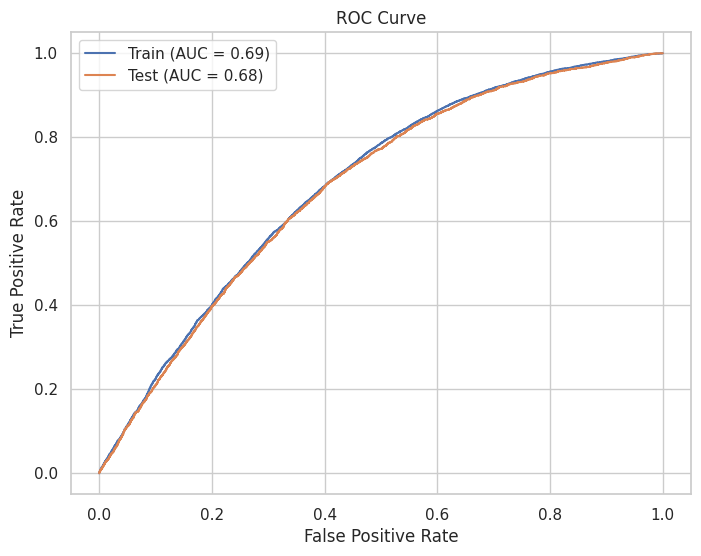

In [ ]:
plt.figure(figsize=(8, 6))
plot_roc_curve(y_u, model.predict_prob(X_u), label='Train')
plot_roc_curve(y_test, a, label='Test')
plt.show()

Cutoff = 55

In [ ]:
cutoff = 55
#print(df_train.shape)
#print(df_train[df_train["popularity"]>80].shape)
#print(y_train[y_train > cutoff].count())
X_u, y_u = underSampling(X_train, y_train, cutoff)
y_test = np.where(y_test_>=cutoff, 1, 0)

#print("CNT TRAIN: ", sum(y_u==0), sum(y_u==1))
#print("### DATASET SIZE ###", X_u.shape)
model.fit(X_u, y_u)

a = model.predict_prob(X_test)
#print(a)
y_pred = model.predict(X_test)
#print("CNT PRED: ", sum(y_pred==0), sum(y_pred==1))
#print(sum(y_test==0), sum(y_test==1))

#print("RESULTS AT CUTOFF ", cutoff)
#accuracy = sum(y_test==y_pred)/y_test.shape
#print("ACCURACY: ", accuracy[0])
#print(confusion_matrix(y_test, y_pred))
#roc(y_test, a, 20, False)

print("RESULTS AT CUTOFF ", cutoff)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, a)

accuracy_metric.append(accuracy)
print("ACCURACY: ", accuracy)
precision_metric.append(precision)
print("PRECISION: ", precision)
recall_metric.append(recall)
print("RECALL: ", recall)
auc_metric.append(auc)
print("AUC: ", auc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RESULTS AT CUTOFF  55
ACCURACY:  0.5708507250742286
PRECISION:  0.11347059366632813
RECALL:  0.768125
AUC:  0.7049058124220159
Confusion Matrix:
[[ 1229  9602]
 [  371 12037]]


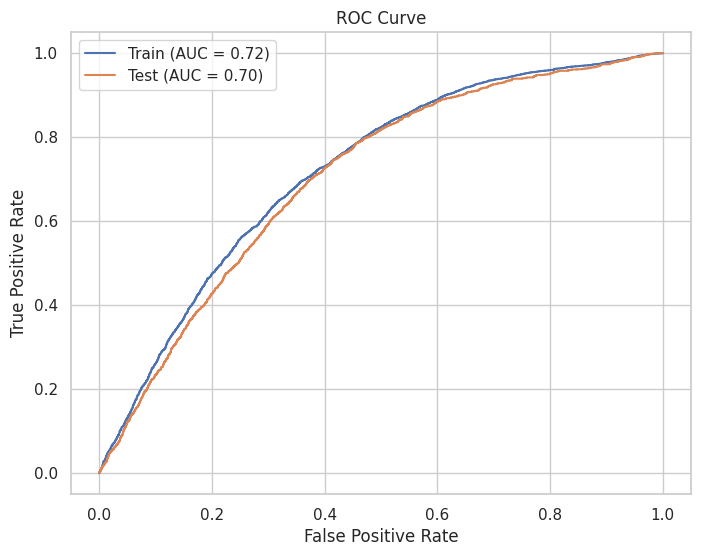

In [ ]:
plt.figure(figsize=(8, 6))
plot_roc_curve(y_u, model.predict_prob(X_u), label='Train')
plot_roc_curve(y_test, a, label='Test')
plt.show()

Cutoff = 65

In [ ]:
cutoff = 65
#print(df_train.shape)
#print(df_train[df_train["popularity"]>80].shape)
#print(y_train[y_train > cutoff].count())
X_u, y_u = underSampling(X_train, y_train, cutoff)
y_test = np.where(y_test_>=cutoff, 1, 0)

#print("CNT TRAIN: ", sum(y_u==0), sum(y_u==1))
#print("### DATASET SIZE ###", X_u.shape)
model.fit(X_u, y_u)

a = model.predict_prob(X_test)
#print(a)
y_pred = model.predict(X_test)
#print("CNT PRED: ", sum(y_pred==0), sum(y_pred==1))
#print(sum(y_test==0), sum(y_test==1))

#print("RESULTS AT CUTOFF ", cutoff)
#accuracy = sum(y_test==y_pred)/y_test.shape
#print("ACCURACY: ", accuracy[0])
#print(confusion_matrix(y_test, y_pred))
#roc(y_test, a, 20, False)

print("RESULTS AT CUTOFF ", cutoff)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, a)

accuracy_metric.append(accuracy)
print("ACCURACY: ", accuracy)
precision_metric.append(precision)
print("PRECISION: ", precision)
recall_metric.append(recall)
print("RECALL: ", recall)
auc_metric.append(auc)
print("AUC: ", auc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RESULTS AT CUTOFF  65
ACCURACY:  0.611299969878222
PRECISION:  0.04118404118404118
RECALL:  0.8050314465408805
AUC:  0.7602364509461408
Confusion Matrix:
[[  384  8940]
 [   93 13822]]


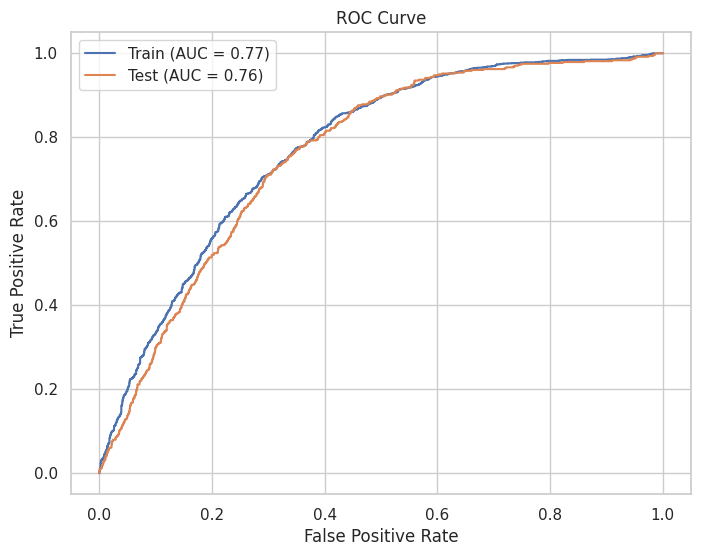

In [ ]:
plt.figure(figsize=(8, 6))
plot_roc_curve(y_u, model.predict_prob(X_u), label='Train')
plot_roc_curve(y_test, a, label='Test')
plt.show()

Cutoff = 75

In [ ]:
cutoff = 75
#print(df_train.shape)
#print(df_train[df_train["popularity"]>80].shape)
#print(y_train[y_train > cutoff].count())
X_u, y_u = underSampling(X_train, y_train, cutoff)
y_test = np.where(y_test_>=cutoff, 1, 0)

#print("CNT TRAIN: ", sum(y_u==0), sum(y_u==1))
#print("### DATASET SIZE ###", X_u.shape)
model.fit(X_u, y_u)

a = model.predict_prob(X_test)
#print(a)
y_pred = model.predict(X_test)
#print("CNT PRED: ", sum(y_pred==0), sum(y_pred==1))
#print(sum(y_test==0), sum(y_test==1))

#print("RESULTS AT CUTOFF ", cutoff)
#accuracy = sum(y_test==y_pred)/y_test.shape
#print("ACCURACY: ", accuracy[0])
#print(confusion_matrix(y_test, y_pred))
#roc(y_test, a, 20, False)

print("RESULTS AT CUTOFF ", cutoff)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, a)

accuracy_metric.append(accuracy)
print("ACCURACY: ", accuracy)
precision_metric.append(precision)
print("PRECISION: ", precision)
recall_metric.append(recall)
print("RECALL: ", recall)
auc_metric.append(auc)
print("AUC: ", auc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RESULTS AT CUTOFF  75
ACCURACY:  0.6693059081716081
PRECISION:  0.012746234067207415
RECALL:  0.853448275862069
AUC:  0.8389372352054306
Confusion Matrix:
[[   99  7668]
 [   17 15455]]


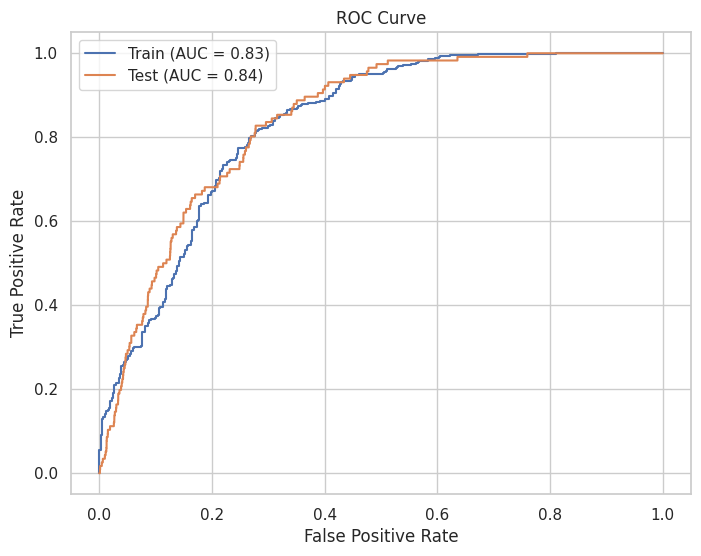

In [ ]:
plt.figure(figsize=(8, 6))
plot_roc_curve(y_u, model.predict_prob(X_u), label='Train')
plot_roc_curve(y_test, a, label='Test')
plt.show()

Cutoff = 80

In [21]:
cutoff = 80
#print(df_train.shape)
#print(df_train[df_train["popularity"]>80].shape)
#print(y_train[y_train > cutoff].count())
X_u, y_u = underSampling(X_train, y_train, cutoff)
y_test = np.where(y_test_>=cutoff, 1, 0)

#print("CNT TRAIN: ", sum(y_u==0), sum(y_u==1))
#print("### DATASET SIZE ###", X_u.shape)
model.fit(X_u, y_u)

a = model.predict_prob(X_test)
#print(a)
y_pred = model.predict(X_test)
#print("CNT PRED: ", sum(y_pred==0), sum(y_pred==1))
#print(sum(y_test==0), sum(y_test==1))

#print("RESULTS AT CUTOFF ", cutoff)
#accuracy = sum(y_test==y_pred)/y_test.shape
#print("ACCURACY: ", accuracy[0])
#print(confusion_matrix(y_test, y_pred))
#roc(y_test, a, 20, False)

print("RESULTS AT CUTOFF ", cutoff)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, a)

accuracy_metric.append(accuracy)
print("ACCURACY: ", accuracy)
precision_metric.append(precision)
print("PRECISION: ", precision)
recall_metric.append(recall)
print("RECALL: ", recall)
auc_metric.append(auc)
print("AUC: ", auc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

model.show_weights(X_train)

RESULTS AT CUTOFF  80
ACCURACY:  0.6919833039287405
PRECISION:  0.005839822024471635
RECALL:  0.84
AUC:  0.8342619345379275
Confusion Matrix:
[[   42  7150]
 [    8 16039]]
Coefficient  0  : Bias  :  -2.2935250087484613
Coefficient  1  :  acousticness  :  0.06733566267585878
Coefficient  2  :  danceability  :  1.138982822504964
Coefficient  3  :  duration_ms  :  -0.014444543859846662
Coefficient  4  :  energy  :  -1.0725147275545
Coefficient  5  :  instrumentalness  :  -1.5293975274124672
Coefficient  6  :  key  :  -0.055608920475778645
Coefficient  7  :  liveness  :  -0.049098844274644726
Coefficient  8  :  loudness  :  3.036718447193639
Coefficient  9  :  mode  :  -0.014665103119509477
Coefficient  10  :  speechiness  :  0.2980456351694161
Coefficient  11  :  tempo  :  -0.003706798842896293
Coefficient  12  :  time_signature  :  -0.4756207930439405
Coefficient  13  :  valence  :  -0.43065207191846194


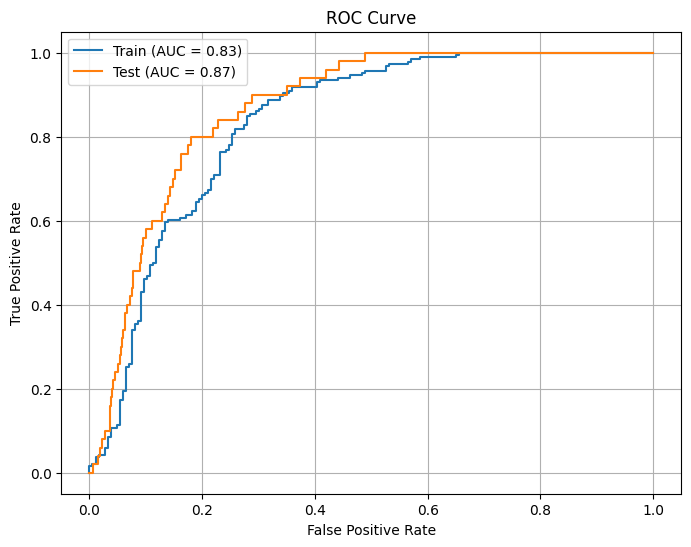

In [13]:
plt.figure(figsize=(8, 6))
plot_roc_curve(y_u, model.predict_prob(X_u), label='Train')
plot_roc_curve(y_test, a, label='Test')
plt.show()

Cutoff = 85

In [ ]:
cutoff = 85
#print(df_train.shape)
#print(df_train[df_train["popularity"]>80].shape)
#print(y_train[y_train > cutoff].count())
X_u, y_u = underSampling(X_train, y_train, cutoff)
y_test = np.where(y_test_>=cutoff, 1, 0)

#print("CNT TRAIN: ", sum(y_u==0), sum(y_u==1))
#print("### DATASET SIZE ###", X_u.shape)
model.fit(X_u, y_u)

a = model.predict_prob(X_test)
#print(a)
y_pred = model.predict(X_test)
#print("CNT PRED: ", sum(y_pred==0), sum(y_pred==1))
#print(sum(y_test==0), sum(y_test==1))

#print("RESULTS AT CUTOFF ", cutoff)
#accuracy = sum(y_test==y_pred)/y_test.shape
#print("ACCURACY: ", accuracy[0])
#print(confusion_matrix(y_test, y_pred))
#roc(y_test, a, 20, False)

print("RESULTS AT CUTOFF ", cutoff)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, a)

accuracy_metric.append(accuracy)
print("ACCURACY: ", accuracy)
precision_metric.append(precision)
print("PRECISION: ", precision)
recall_metric.append(recall)
print("RECALL: ", recall)
auc_metric.append(auc)
print("AUC: ", auc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RESULTS AT CUTOFF  85
ACCURACY:  0.6640561125693877
PRECISION:  0.0031940718027341254
RECALL:  0.8333333333333334
AUC:  0.843458715728094
Confusion Matrix:
[[   25  7802]
 [    5 15407]]


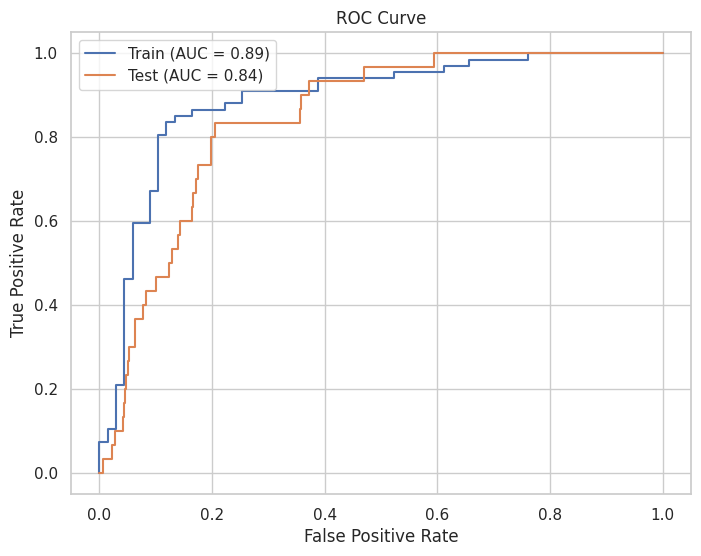

In [ ]:
plt.figure(figsize=(8, 6))
plot_roc_curve(y_u, model.predict_prob(X_u), label='Train')
plot_roc_curve(y_test, a, label='Test')
plt.show()

Cutoff = 90

In [ ]:
cutoff = 90
#print(df_train.shape)
#print(df_train[df_train["popularity"]>80].shape)
#print(y_train[y_train > cutoff].count())
X_u, y_u = underSampling(X_train, y_train, cutoff)
y_test = np.where(y_test_>=cutoff, 1, 0)

#print("CNT TRAIN: ", sum(y_u==0), sum(y_u==1))
#print("### DATASET SIZE ###", X_u.shape)
model.fit(X_u, y_u)

a = model.predict_prob(X_test)
#print(a)
y_pred = model.predict(X_test)
#print("CNT PRED: ", sum(y_pred==0), sum(y_pred==1))
#print(sum(y_test==0), sum(y_test==1))

#print("RESULTS AT CUTOFF ", cutoff)
#accuracy = sum(y_test==y_pred)/y_test.shape
#print("ACCURACY: ", accuracy[0])
#print(confusion_matrix(y_test, y_pred))
#roc(y_test, a, 20, False)

print("RESULTS AT CUTOFF ", cutoff)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, a)

accuracy_metric.append(accuracy)
print("ACCURACY: ", accuracy)
precision_metric.append(precision)
print("PRECISION: ", precision)
recall_metric.append(recall)
print("RECALL: ", recall)
auc_metric.append(auc)
print("AUC: ", auc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RESULTS AT CUTOFF  90
ACCURACY:  0.6629803347820474
PRECISION:  0.0008933129147524247
RECALL:  0.7
AUC:  0.7741616083344096
Confusion Matrix:
[[    7  7829]
 [    3 15400]]


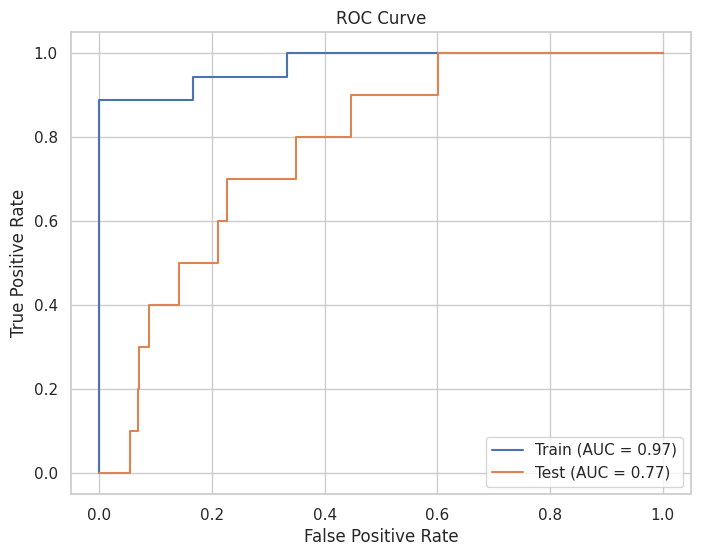

In [ ]:
plt.figure(figsize=(8, 6))
plot_roc_curve(y_u, model.predict_prob(X_u), label='Train')
plot_roc_curve(y_test, a, label='Test')
plt.show()

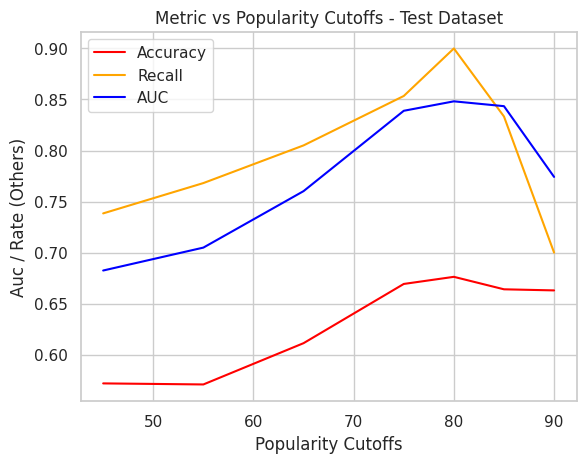

In [ ]:
cutoff_values = [45,55,65,75,80,85,90]

plt.plot(cutoff_values, accuracy_metric, color = 'red', label='Accuracy')
plt.plot(cutoff_values, recall_metric, color = 'orange', label='Recall')
plt.plot(cutoff_values, auc_metric, color = 'blue', label='AUC')
plt.xlabel('Popularity Cutoffs')
plt.ylabel('Auc / Rate (Others)')
#plt.grid(axis='x')
#plt.grid(axis='y')
plt.title('Metric vs Popularity Cutoffs - Test Dataset')
plt.legend()
plt.show()